In [3]:
import sys
sys.path.append("/Users/carla/Desktop/GitHub/Projet-RNCP") 
import pandas as pd
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from src.utils.transformation import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Données réelles

In [1]:
df = pd.read_csv('database_clean.csv',parse_dates=['publishedAt','extractedAt'])
df = df.dropna(subset=['comment'])
df['comment_length'] = df['comment'].str.len()
#df.head(16)

NameError: name 'pd' is not defined

In [3]:
df.shape

(1730, 9)

In [4]:
yt = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/data/youtube_comments_cleaned.csv')
print(yt.shape)
yt.head()

(1032225, 12)


,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2


# Données d'entrainement

In [6]:
df_tweets = pd.read_csv('../data/french_tweets.csv') # les tweets
df_yt = pd.read_csv('/Users/carla/Downloads/partial_translation_1754895688.csv') # les commentaires youtube traduits en français
df_alloc = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/data/test.csv') # les commentaires allociné
df_yt_trad = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/recovered_translations_20250907_2042.csv')

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_2387/2974595845.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_yt_trad = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/recovered_translations_20250907_2042.csv')


In [12]:
df_yt.head()

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1,Quelqu'un sait quel film c'est ?
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17,Le fait qu'ils se retiennent tout en étant aus...
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27,Vous attendez la prochaine vidéo ?
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27,Merci pour la grande vidéo. Je ne comprends pa...
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2,"C'est comme ça qu'on est en Amérique, à l'exce..."


In [7]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # rendre les résultats reproductibles

def detect_lang_safe(text):
    text = str(text).strip()
    # si le texte est trop court ou ne contient pas de lettres, on retourne "unknown"
    if not text or len(text) < 3 or text.isnumeric():
        return "unknown"
    try:
        return detect(text)
    except:
        return "unknown"

df_yt_trad['text_fr'] = df_yt_trad['text_fr'].fillna(" ").astype(str)
df_yt_trad['lang'] = df_yt_trad['text_fr'].apply(detect_lang_safe)

In [8]:
df_yt_trad = df_yt_trad[df_yt_trad['lang'] == "fr"].reset_index(drop=True)

In [13]:
import pickle
with open("df_yt_trad.csv", "w") as f:
    df_yt_trad.to_csv(f)

In [12]:
df_yt_trad.head(20)

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr,lang
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1,Quelqu'un sait de quel film c'est?,fr
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17,Le fait qu'ils se retiennent tout en étant le ...,fr
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27,La prochaine vidéo en attente sera?,fr
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video. I don't understan...,Neutral,0,1,2024-09-18 12:04:12,US,27,Merci pour la super vidéo. Je ne comprends pas...,fr
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people. This is how i...,Positive,3,1,2025-01-10 19:39:03,US,2,Bonne personne aidant les bonnes personnes. C'...,fr
5,UgzJ-2rV0-YNPyMj0u14AaABAg,X4wNLFrv9Co,Which one will you choose to use the cola keyc...,@JasmineHatchel-c3c,UCHvnyO2K7-1oXXdWQh0510g,Number two because it looks the best with it,Positive,0,0,2025-01-10 06:00:19,US,28,Numéro deux car il a l'air le meilleur avec,fr
6,UgwuFh4s9cHu3dHrPqJ4AaABAg,sKniMxl9zwo,Trump’s Reaction During ‘Abuse of Power’ Says ...,@StaceyBrown-h6o,UCzTaRiUaLcaLD9I0l2tCBCA,Thank God we don’t have to listen to his drive...,Positive,0,0,2025-01-14 01:24:48,IE,25,"Dieu merci, nous n'avons plus à écouter son ra...",fr
7,UgwzYX76p4RK8AHVcYN4AaABAg,yUImrnDqGUk,Thank god this angel found this beautiful dog ...,@cassiegerst6123,UC-QvE5-ZberkWmSYDXLvfQA,Very similar thing happened to me! We lived ne...,Positive,0,0,2025-01-14 03:54:19,AU,15,Une chose très similaire m'est arrivée! Nous v...,fr
8,UgzW7h-gmtmgIFFClLJ4AaABAg,5VPxcrvVkBc,He betrayed his own friend - Enjoying a cup of...,@josh_playz2709,UCflV1g1fmgs5i2QZwiaHT8g,im about to cry😢,Negative,0,0,2025-01-13 09:55:03,IE,20,Je suis sur le point de pleurer😢,fr
9,UgyqrXh3SW_NpUqyc_Z4AaABAg,eWRfhZUzrAc,Python for Beginners – Full Course [Programmin...,@t.a-8469,UCELGbox9iW4QjIJF37s9E-Q,This is really valuable information and I appr...,Neutral,1,0,2024-02-01 07:16:35,US,27,Ce sont des informations vraiment précieuses e...,fr


In [4]:

# df_yt_fr = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/data/youtube_comments_cleaned.csv')
# df_yt_fr.groupby('VideoTitle')['CommentID'].count().reset_index().sort_values(by='CommentID', ascending=False)


In [9]:
# df_yt_fr[df_yt_fr['VideoID'] == 'Lzccd-ol1Ks'].head(10)
# # BTLcjQUued8Cc4qYw

In [62]:
import pandas as pd
trad = pd.read_csv('/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/translated_dataset_20250905_2324.csv')
print(trad.shape)
trad.head()

(1002, 13)


,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1.0,Quelqu'un sait de quel film c'est?
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17.0,Le fait qu'ils se retiennent tout en étant le ...
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27.0,La prochaine vidéo en attente sera?
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27.0,Merci pour la super vidéo.\n\nJe ne comprends ...
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2.0,Bonne personne aidant les bonnes personnes.\nC...


# EDA

In [8]:
df_tweets.shape, df_yt.shape, df_alloc.shape

((1526724, 2), (25000, 13), (20000, 4))

In [14]:
df_tweets.info(), df_yt.info(), df_alloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526724 entries, 0 to 1526723
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1526724 non-null  int64 
 1   text    1526724 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentID        25000 non-null  object
 1   VideoID          25000 non-null  object
 2   VideoTitle       25000 non-null  object
 3   AuthorName       24982 non-null  object
 4   AuthorChannelID  25000 non-null  object
 5   CommentText      25000 non-null  object
 6   Sentiment        25000 non-null  object
 7   Likes            25000 non-null  int64 
 8   Replies          25000 non-null  int64 
 9   PublishedAt      25000 non-null  object
 10  CountryCode      25000 non-null

(None, None, None)

In [15]:
# le nombre de commentaires (id) par vidéo (videoid) en ordor décroissant du nombre de commentaires
df_yt.groupby('VideoID')['CommentID'].count().reset_index().sort_values(by='CommentID', ascending=False)


,VideoID,CommentID
2159,TloMiwQv1x4,34
1603,Lzccd-ol1Ks,34
58,-hV6aeyPHPA,32
152,1DsMZuJm5Sg,31
121,0gASceRnltg,31
...,...,...
1500,KKgN_w71x3E,1
2907,dQlw1Cdd3pw,1
1486,K7ghUiXLef8,1
2913,dYrniSWkLAY,1


/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


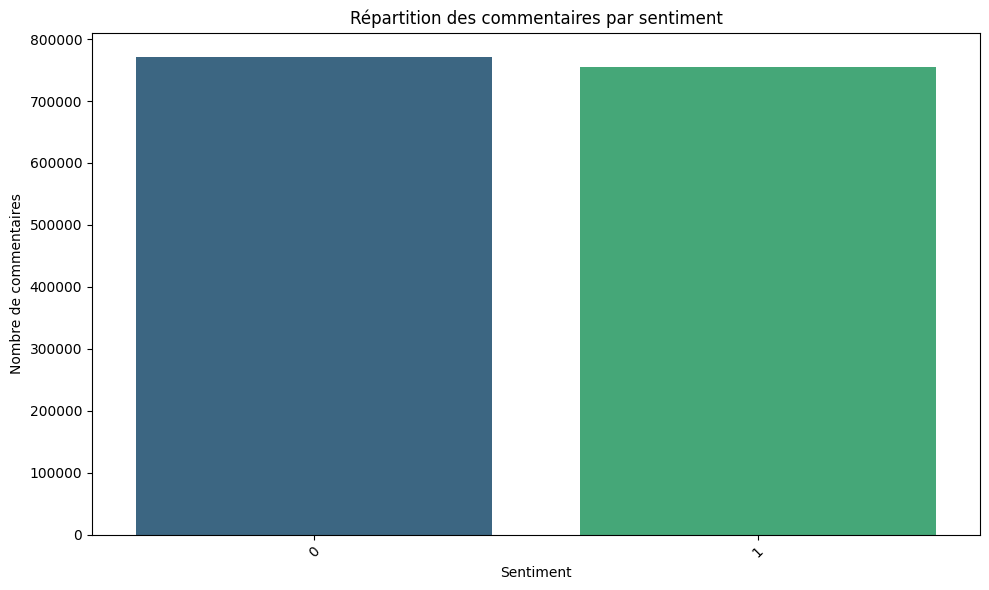

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


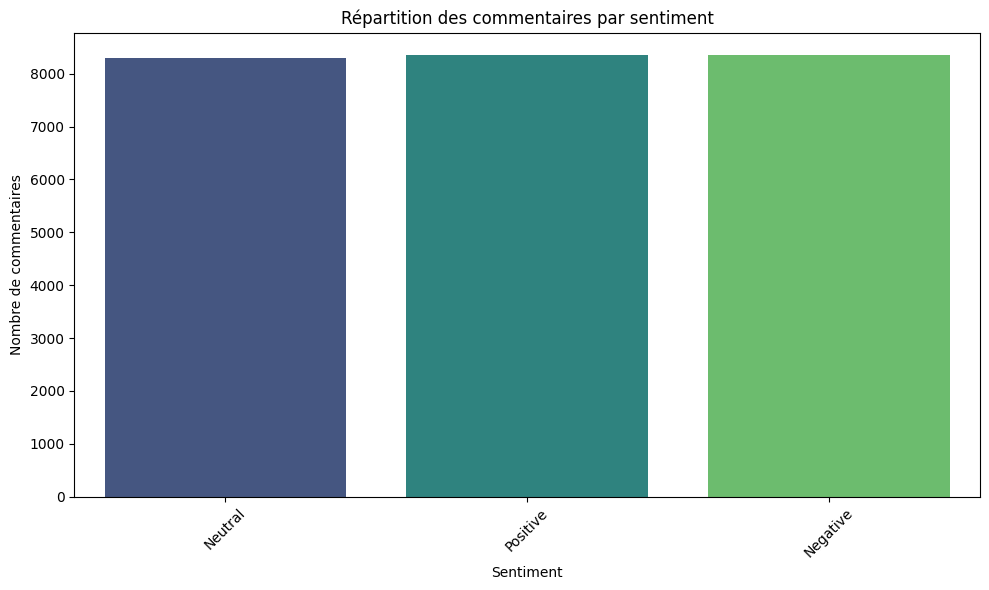

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


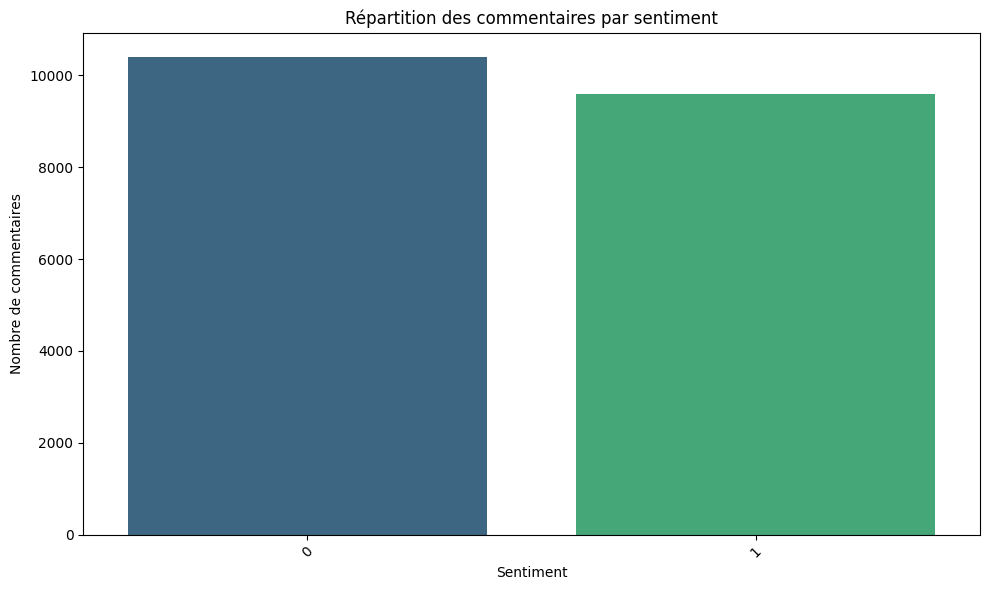

/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_11932/4182401319.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=x, palette='viridis')


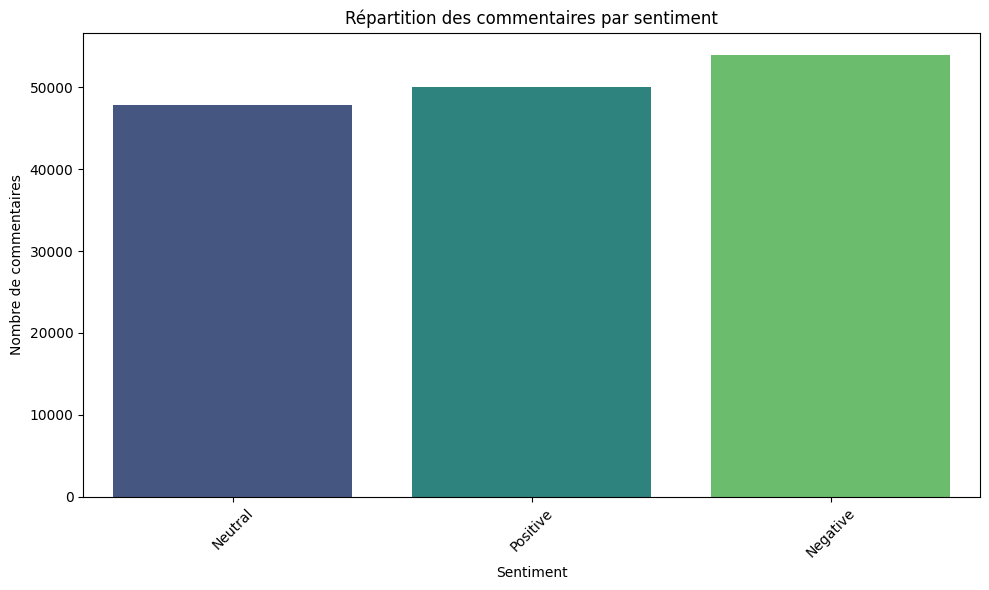

In [26]:
# graphique répartition des commentaires par sentiment
def plot_sentiment_distribution(df : pd.DataFrame, x :str) :
    """
    Affiche la répartition des sentiments dans le DataFrame.
    
    :param df: DataFrame contenant les sentiments
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=x, palette='viridis')
    plt.title('Répartition des commentaires par sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de commentaires')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_sentiment_distribution(df_tweets, 'label')

plot_sentiment_distribution(df_yt, 'Sentiment')

plot_sentiment_distribution(df_alloc, 'polarity')

# plot_sentiment_distribution(trad, 'Sentiment')

plot_sentiment_distribution(df_yt_trad, 'Sentiment')

In [12]:
from langdetect import detect
# filtre de data set sur les commentaires en anglais
def safe_detect(text):
    try:
        return detect(text.strip()) if isinstance(text, str) and text.strip() else None
    except Exception as e:
        return None  # Return None if detection fails


# ANALYSE DE SIMILARITÉ

In [31]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_tweets['text']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

def get_vocab(texts):
        """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
        vocab = set()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            vocab.update(words)
        return vocab

dataset_vocab = get_vocab(df_tweets['text'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_tweets['text']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_tweets['text'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.0627231978668098,
 'length_effect_size': 0.0015042652996436574,
 'length_similar': True,
 'jaccard': 0.015,
 'coverage_to_yt': 0.015,
 'coverage_from_yt': 0.849,
 'tfidf_cosine': 0.676,
 'composite_score': 0.439,
 'dataset_vocab_size': 253124,
 'youtube_vocab_size': 4552,
 'common_words': 3864,
 'dataset_avg_length': 14.1,
 'youtube_avg_length': 17.8}

In [32]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_alloc['review']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

def get_vocab(texts):
        """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
        vocab = set()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            vocab.update(words)
        return vocab

dataset_vocab = get_vocab(df_alloc['review'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_alloc['review']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_alloc['review'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.0,
 'length_effect_size': 0.38080508517052697,
 'length_similar': False,
 'jaccard': 0.061,
 'coverage_to_yt': 0.062,
 'coverage_from_yt': 0.78,
 'tfidf_cosine': 0.639,
 'composite_score': 0.429,
 'dataset_vocab_size': 57023,
 'youtube_vocab_size': 4552,
 'common_words': 3552,
 'dataset_avg_length': 92.5,
 'youtube_avg_length': 17.8}

In [33]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_yt['text_fr']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

def get_vocab(texts):
        """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
        vocab = set()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            vocab.update(words)
        return vocab

dataset_vocab = get_vocab(df_yt['text_fr'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_yt['text_fr']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_yt['text_fr'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.27747154618981473,
 'length_effect_size': 0.0066388252969118945,
 'length_similar': True,
 'jaccard': 0.085,
 'coverage_to_yt': 0.089,
 'coverage_from_yt': 0.651,
 'tfidf_cosine': 0.746,
 'composite_score': 0.416,
 'dataset_vocab_size': 33469,
 'youtube_vocab_size': 4552,
 'common_words': 2963,
 'dataset_avg_length': 18.4,
 'youtube_avg_length': 17.8}

In [23]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_yt['text_fr']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

# def get_vocab(texts):
#         """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
#         vocab = set()
#         for text in texts:
#             words = re.findall(r'\b\w+\b', text.lower())
#             vocab.update(words)
#         return vocab

def get_vocab(texts):
    """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
    vocab = set()
    for text in texts:
        if not isinstance(text, str):  # Skip non-string values
            continue
        words = re.findall(r'\b\w+\b', text.lower())
        vocab.update(words)
    return vocab

dataset_vocab = get_vocab(trad['text_fr'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_yt['text_fr']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_yt['text_fr'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 0.27747154618981473,
 'length_effect_size': 0.0066388252969118945,
 'length_similar': True,
 'jaccard': 0.173,
 'coverage_to_yt': 0.283,
 'coverage_from_yt': 0.309,
 'tfidf_cosine': 0.746,
 'composite_score': 0.357,
 'dataset_vocab_size': 4981,
 'youtube_vocab_size': 4552,
 'common_words': 1408,
 'dataset_avg_length': 18.4,
 'youtube_avg_length': 17.8}

In [34]:
from scipy.stats import mannwhitneyu
dataset_lengths = [len(text.split()) for text in df_yt_trad['text_fr']]
youtube_lengths = [len(text.split()) for text in df['comment']]

# Test Mann-Whitney U
stat, pvalue = mannwhitneyu(dataset_lengths, youtube_lengths, alternative='two-sided')

# Effect size (r de Rosenthal)
n = len(dataset_lengths) + len(youtube_lengths)
z_score = (stat - len(dataset_lengths) * len(youtube_lengths) / 2) / np.sqrt(len(dataset_lengths) * len(youtube_lengths) * n / 12)
effect_size = abs(z_score) / np.sqrt(n)

# def get_vocab(texts):
#         """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
#         vocab = set()
#         for text in texts:
#             words = re.findall(r'\b\w+\b', text.lower())
#             vocab.update(words)
#         return vocab

def get_vocab(texts):
    """Extrait le vocabulaire unique (mots en minuscules, sans ponctuation)"""
    vocab = set()
    for text in texts:
        if not isinstance(text, str):  # Skip non-string values
            continue
        words = re.findall(r'\b\w+\b', text.lower())
        vocab.update(words)
    return vocab

dataset_vocab = get_vocab(df_yt_trad['text_fr'])
youtube_vocab = get_vocab(df['comment'])

# Jaccard Index
intersection = len(dataset_vocab.intersection(youtube_vocab))
union = len(dataset_vocab.union(youtube_vocab))
jaccard = intersection / union if union > 0 else 0

# Coverage bidirectionnel
coverage_to_yt = intersection / len(dataset_vocab) if len(dataset_vocab) > 0 else 0
coverage_from_yt = intersection / len(youtube_vocab) if len(youtube_vocab) > 0 else 0

from sklearn.metrics.pairwise import cosine_similarity
min_size = min(len(df_yt_trad['text_fr']), len(df['comment']), 1000)  # Max 1000 pour performance

np.random.seed(42)  # Reproductibilité
dataset_sample = np.random.choice(df_yt_trad['text_fr'], min_size, replace=False).tolist()
youtube_sample = np.random.choice(df['comment'], min_size, replace=False).tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, lowercase=True)
all_texts = dataset_sample + youtube_sample
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Vecteurs moyens
dataset_tfidf = tfidf_matrix[:min_size].mean(axis=0)
youtube_tfidf = tfidf_matrix[min_size:].mean(axis=0)
dataset_tfidf = np.asarray(dataset_tfidf)
youtube_tfidf = np.asarray(youtube_tfidf)

# Similarité cosinus
tfidf_cosine = cosine_similarity(dataset_tfidf, youtube_tfidf)[0, 0]

# ========== SCORE COMPOSITE ==========
# Pondération : coverage_from_yt le plus important pour les performances
composite_score = (
    jaccard * 0.25 +
    coverage_to_yt * 0.2 +
    coverage_from_yt * 0.35 +
    tfidf_cosine * 0.2
)

{
        # Longueurs
        'length_pvalue': pvalue,
        'length_effect_size': effect_size,
        'length_similar': pvalue > 0.05 or effect_size < 0.3,
        
        # Vocabulaire
        'jaccard': round(jaccard, 3),
        'coverage_to_yt': round(coverage_to_yt, 3),
        'coverage_from_yt': round(coverage_from_yt, 3),
        'tfidf_cosine': round(tfidf_cosine, 3),
        
        # Score final
        'composite_score': round(composite_score, 3),
        
        # Statistiques descriptives
        'dataset_vocab_size': len(dataset_vocab),
        'youtube_vocab_size': len(youtube_vocab),
        'common_words': intersection,
        'dataset_avg_length': round(np.mean(dataset_lengths), 1),
        'youtube_avg_length': round(np.mean(youtube_lengths), 1)
    }

{'length_pvalue': 8.89185936102673e-29,
 'length_effect_size': 0.028385610266154326,
 'length_similar': True,
 'jaccard': 0.044,
 'coverage_to_yt': 0.044,
 'coverage_from_yt': 0.766,
 'tfidf_cosine': 0.74,
 'composite_score': 0.436,
 'dataset_vocab_size': 78394,
 'youtube_vocab_size': 4552,
 'common_words': 3488,
 'dataset_avg_length': 22.9,
 'youtube_avg_length': 17.8}

# classification

In [10]:
# df_fr = main_transformation(df_yt, 'text_fr','/Users/carla/Desktop/GitHub/Projet-RNCP/extra_expressions.txt')
# df_fr.head()

In [63]:
# print(f"la forme avant {trad.shape}")
# index = []
# for i in range(len(trad)):
#     # print(type(trad['text_fr'].iloc[i]))
#     if not isinstance(trad['text_fr'].iloc[i], str):
#         # trad = pd.DataFrame(trad.drop(trad.index[i], axis=0, inplace=True))
#         index.append(i)
#         # print(type(trad))
# trad = pd.DataFrame(trad.drop(labels=index, axis=0))
# print(f"la forme après {trad.shape}")


la forme avant (1002, 13)
la forme après (987, 13)


## preprocessing

In [4]:
df_yt_trad = pd.read_csv("/Users/carla/Desktop/GitHub/Projet-RNCP/notebooks/df_yt_trad.csv")

In [5]:
df_yt_trad.shape

(151884, 15)

In [16]:
df_yt_trad['text_fr'] = df_yt_trad['text_fr'].fillna('').astype(str)

In [6]:
# precpocessing 
from src.utils.transformation import preprocessing
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer


path = '/Users/carla/Desktop/GitHub/Projet-RNCP/extra_expressions.txt'
df_yt_trad['comment_clean_lem'] = df_yt_trad['text_fr'].astype(str).apply(lambda x: preprocessing(x, join=True, path=path))
df_yt_trad['tokens_clean_lem'] = df_yt_trad['text_fr'].apply(lambda x: preprocessing(x, join=False, path=path))

In [7]:
# vectorisation 
## w2vec
# Exemple de corpus
sentences = df_yt_trad['comment_clean_lem'].dropna().tolist()
tokenized_sentences = [simple_preprocess(sent) for sent in sentences if sent.strip() != '']



In [8]:
model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

def get_sentence_vector(sentence, model):
    if pd.isna(sentence):  # Gestion des valeurs NaN
        return np.zeros(model.vector_size)
    words = simple_preprocess(sentence)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # moyenne des vecteurs
    else:
        return np.zeros(model.vector_size)
    


In [9]:
df_yt_trad['w2vec_vector'] = df_yt_trad['comment_clean_lem'].apply(lambda x: get_sentence_vector(x, model_w2v))

## tfidf
# Exemple de corpus
corpus = df_yt_trad['text_fr'].tolist()  # Assurez-vous que les commentaires ne sont pas vides .dropna()



In [10]:
# Initialisation du vecteur TF-IDF
vectorizer = TfidfVectorizer()


In [11]:
# Entraînement du modèle TF-IDF
tfidf_matrix = vectorizer.fit_transform(corpus)


In [12]:
# ajouter une colonne avec les vecteurs TF-IDF
df_yt_trad['tfidf_vector'] = list(tfidf_matrix.toarray())

In [4]:
# # vectorisation du texte
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess

# # text_fr = pd.read_csv("../data/youtube_comments_fr_translated_marian.csv")

# # Exemple de corpus
# sentences = df_train2['comment_clean_lem'].dropna().tolist()  # Assurez-vous que les commentaires ne sont pas vides

# # Prétraitement (tokenisation simple)
# tokenized_sentences = [simple_preprocess(sent) for sent in sentences]

# # Entraînement Word2Vec (skip-gram)
# model_w2v = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

# # # Exemple : obtenir le vecteur pour le mot 'apprendre'
# # # vector_apprendre = model_w2v.wv['apprendre']
# # # print(f"Vector for 'apprendre' (Word2Vec):\n{vector_apprendre}")

# # # Trouver mots similaires
# # # similaires = model_w2v.wv.most_similar('apprendre', topn=3)
# # # print("Mots les plus similaires à 'apprendre' :", similaires)


In [11]:
# import inspect
# import sys
# import importlib

# module_name = "src.utils.transformation"

# # Remove the module from the cache
# if module_name in sys.modules:
#     del sys.modules[module_name]

# # Import and reload the module
# from src.utils.transformation import * 

# inspect.signature(main_transformation).parameters

In [255]:
# def get_sentence_vector(sentence, model):
#     words = simple_preprocess(sentence)
#     word_vectors = [model.wv[word] for word in words if word in model.wv]
#     if len(word_vectors) > 0:
#         return np.mean(word_vectors, axis=0)  # moyenne des vecteurs
#     else:
#         return np.zeros(model.vector_size)
    
# df_fr['w2vec_vector'] = df_fr['comment_clean_lem'].apply(lambda x: get_sentence_vector(x, model_w2v))

In [6]:
# # vectorisation tfidf
# from sklearn.feature_extraction.text import TfidfVectorizer
# # Exemple de corpus
# corpus = df_train2['text_fr'].dropna().tolist()  # Assurez-vous que les commentaires ne sont pas vides
# # Initialisation du vecteur TF-IDF
# vectorizer = TfidfVectorizer()
# # Entraînement du modèle TF-IDF
# tfidf_matrix = vectorizer.fit_transform(corpus)
# # ajouter une colonne avec les vecteurs TF-IDF
# df_fr['tfidf_vector'] = list(tfidf_matrix.toarray())

# # def get_tfidf_vector(df, text='comment_clean_lem'):
# #     """
# #     Obtenir le vecteur TF-IDF d'une phrase
# #     """
# #     vectorizer = TfidfVectorizer()
# #     corpus = df[text].dropna().tolist()
# #     tfidf_matrix = vectorizer.fit_transform(corpus)
# #     df['tfidf_vector'] = list(tfidf_matrix.toarray())
# #     return df


In [11]:
# # ajouter une colonne avec le texte vectoriser
# df_fr['vector'] = df_fr['comment_clean_lem'].apply(lambda x: model_w2v.wv[simple_preprocess(x)] if pd.notnull(x) else None)
# df_fr.head(10)

In [13]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_yt_trad['Sentiment'].values)
# label_encoder.classes_



In [14]:
# Conversion en matrices NumPy 2D
# x_knn = np.vstack(df_yt_trad['w2vec_vector'].values)
# x = np.vstack(df_yt_trad['tfidf_vector'].values)
x = tfidf_matrix
# -- convertit w2v en matrice dense 2D (doit avoir le même nombre de lignes)
x_knn = np.vstack(df_yt_trad['w2vec_vector'].values).astype(np.float32)
print("X_w2v shape:", x_knn.shape)
print("X_ shape:", x.shape)


X_w2v shape: (151884, 100)
X_ shape: (151884, 78252)


In [ ]:
# # Séparation des données en ensembles d'entraînement et de test
# x_knn = np.array(df_yt_trad['w2vec_vector'].tolist())
# x = np.array(df_yt_trad['tfidf_vector'].tolist())
# # w = np.array(df_yt_trad['text_fr'].tolist())

: 

In [15]:
w = np.array(df_yt_trad['text_fr'].tolist())

In [16]:
x_train, x_test, x_knn_train, x_knn_test, w_train, w_test, y_train, y_test  = train_test_split(x, x_knn,w, y, test_size=0.2, random_state=42) #, w_train, w_test  w,
# print(f"Train set size: {len(x_train)}, Test set size: {len(x_test)}")
print(f"les shapes des données d'entraînement et de test: {x_train.shape}, {x_test.shape}")
print(f"les shapes des labels d'entraînement et de test: {y_train.shape}, {y_test.shape}")
print(f"les shapes des texts d'entraînement et de test: {w_train.shape}, {w_test.shape}")
print(f"les shapes des vecteurs d'entraînement et de test: {x_knn_train.shape}, {x_knn_test.shape}")
print(label_encoder.classes_)


les shapes des données d'entraînement et de test: (121507, 78252), (30377, 78252)
les shapes des labels d'entraînement et de test: (121507,), (30377,)
les shapes des texts d'entraînement et de test: (121507,), (30377,)
les shapes des vecteurs d'entraînement et de test: (121507, 100), (30377, 100)
['Negative' 'Neutral' 'Positive']


## entrainement et évaluation

In [26]:
accuracy =[]
fscores = []

print("Entraînement des modèles de classification...")

# Entraînement du modèle Random Forest
rf= RandomForestClassifier(n_estimators=100, random_state=42)
# entraienellement du modèle arbre de décision
dt = DecisionTreeClassifier(random_state=42)
# entraienellement du modèle SVM
# svm = SVC(kernel='linear', random_state=42)
# entraienellement du modèle régression logistique
lr = LogisticRegression(max_iter=1000, random_state=42)
# entraienellement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
# entraienellement du modèle Naive Bayes
nb = MultinomialNB()

print("Entraînement du modèle Random Forest...")
rf.fit(x_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_rf = rf.predict(x_test)
# Évaluation du modèle
from sklearn.metrics import classification_report, accuracy_score
print(f"Classification Report\n:{classification_report(y_test, y_pred_rf)}")
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", {acc_rf})
accuracy.append(acc_rf)
fscore_rf = f1_score(y_test, y_pred_rf, average='weighted')
fscores.append(fscore_rf)
print("F1 Score:", fscore_rf)


print("Entraînement du modèle Arbre de Décision...")
dt.fit(x_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_dt = dt.predict(x_test)
# Évaluation du modèle
print(f"Classification Report\n:{classification_report(y_test, y_pred_dt)}")
acc_dt = accuracy_score(y_test, y_pred_dt)
accuracy.append(acc_dt)
print("Accuracy:", acc_dt)
fscore_dt = f1_score(y_test, y_pred_dt, average='weighted')
fscores.append(fscore_dt)
print("F1 Score:", fscore_dt)

# print("Entraînement du modèle SVM...")
# svm.fit(x_train, y_train)
# # Prédictions sur l'ensemble de test
# y_pred_svm = svm.predict(x_test)
# # Évaluation du modèle
# print(f"Classification Report\n:{classification_report(y_test, y_pred_svm)}")
# acc_svm = accuracy_score(y_test, y_pred_svm)
# accuracy.append(acc_svm)
# print("Accuracy:", acc_svm)
# fscore_svm = f1_score(y_test, y_pred_svm, average='weighted')
# fscores.append(fscore_svm)
# print("F1 Score:", fscore_svm)

print("Entraînement du modèle Regression logistique...")
lr.fit(x_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_lr = lr.predict(x_test)
# Évaluation du modèle
print(f"Classification Report\n:{classification_report(y_test, y_pred_lr)}")
acc_lr = accuracy_score(y_test, y_pred_lr)
accuracy.append(acc_lr)
print("Accuracy:", acc_lr)
fscore_lr = f1_score(y_test, y_pred_lr, average='weighted')
fscores.append(fscore_lr)
print("F1 Score:", fscore_lr)

print("Entraînement du modèle KNN...")
knn.fit(x_knn_train, y_train)
# Prédictions sur l'ensemble de test
y_pred_knn = knn.predict(x_knn_test)
# Évaluation du modèle
print(f"Classification Report\n:{classification_report(y_test, y_pred_knn)}")
acc_knn = accuracy_score(y_test, y_pred_knn)
accuracy.append(acc_knn)
print("Accuracy:", acc_knn)
fscore_knn = f1_score(y_test, y_pred_knn, average='weighted')
fscores.append(fscore_knn)
print("F1 Score:", fscore_knn)


Entraînement des modèles de classification...
Entraînement du modèle Random Forest...
Classification Report
:              precision    recall  f1-score   support

           0       0.58      0.72      0.65     10850
           1       0.56      0.52      0.54      9462
           2       0.75      0.61      0.67     10065

    accuracy                           0.62     30377
   macro avg       0.63      0.62      0.62     30377
weighted avg       0.63      0.62      0.62     30377

Accuracy: {0.6215887019784706}
F1 Score: 0.621113509826282
Entraînement du modèle Arbre de Décision...
Classification Report
:              precision    recall  f1-score   support

           0       0.52      0.52      0.52     10850
           1       0.45      0.47      0.46      9462
           2       0.58      0.56      0.57     10065

    accuracy                           0.52     30377
   macro avg       0.52      0.52      0.52     30377
weighted avg       0.52      0.52      0.52     30377

Acc

In [ ]:
# text raw
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
predictions = []
for text in w_test:
    vs = tb(text).sentiment[0]
    if (vs > 0):
        predictions.append(2)#2
    elif (vs < 0):
        predictions.append(0)#0
    else:
        predictions.append(1)#1
y_pred_txtb = np.array(predictions)
# label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Adaptez selon vos labels
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_textb_mapped = [label_mapping.get(pred, 1) for pred in y_pred_txtb]
#     y_pred_txtb = np.array(y_pred_textb_mapped)

print(f"Classification Report:\n{classification_report(y_test, y_pred_txtb)}")
acc_textb = accuracy_score(y_test, y_pred_txtb)
accuracy.append(acc_textb)
print(f"Accuracy: {acc_textb:.4f}")
fscore_textb = f1_score(y_test, y_pred_txtb, average='weighted')
fscores.append(fscore_textb)
print(f"F1 Score: {fscore_textb:.4f}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.32      0.41     10850
           1       0.45      0.39      0.42      9462
           2       0.45      0.73      0.56     10065

    accuracy                           0.48     30377
   macro avg       0.50      0.48      0.46     30377
weighted avg       0.50      0.48      0.46     30377

Accuracy: 0.4773
F1 Score: 0.4625



In [ ]:
from textblob import TextBlob
def get_sentiment_textblob(text):
    """Analyse de sentiment avec TextBlob"""
    try:
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            return 2 # positive
        elif polarity < -0.1:
            return 0 # negative
        else:
            return 1 # neutral
    except:
        return 1 # neutral in case of error

predictions_textblob = []
for text in w_test:
    sentiment = get_sentiment_textblob(text)
    predictions_textblob.append(sentiment)

y_pred_textblob = np.array(predictions_textblob)
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_textblob_mapped = [label_mapping.get(pred, 1) for pred in y_pred_textblob]
#     y_pred_textblob = np.array(y_pred_textblob_mapped)

print("RÉSULTATS TEXTBLOB:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_textblob)}")
acc_textblob = accuracy_score(y_test, y_pred_textblob)
accuracy.append(acc_textblob)
print(f"Accuracy: {acc_textblob:.4f}")
fscore_textblob = f1_score(y_test, y_pred_textblob, average='weighted')
fscores.append(fscore_textblob)
print(f"F1 Score: {fscore_textblob:.4f}\n")


RÉSULTATS TEXTBLOB:
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.05      0.09     10850
           1       0.32      0.90      0.47      9462
           2       0.50      0.15      0.23     10065

    accuracy                           0.35     30377
   macro avg       0.46      0.37      0.26     30377
weighted avg       0.46      0.35      0.25     30377

Accuracy: 0.3464
F1 Score: 0.2547



In [ ]:
from transformers import pipeline
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True, max_length=512, 
)
def get_sentiment(text : str, classifier, all=False ) -> str:
    res = classifier(text)[0]
    max_result = max(res, key=lambda x: x['score'])
    if all == True :
        return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
    else:
        return max_result['label']
    
predictions_distilbert = []
for text in w_test:
    sentiment = get_sentiment(text, classifier=distilled_student_sentiment_classifier)
    # print(sentiment)
    if sentiment == "Positive":
        predictions_distilbert.append(2) # positive
    elif sentiment == "Negative":
        predictions_distilbert.append(0)
    elif sentiment == "Neutral":
        predictions_distilbert.append(1)
    else:
        predictions_distilbert.append(1)

y_pred_distilbert = np.array(predictions_distilbert)

print(y_pred_distilbert)
print("RÉSULTATS vader:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_distilbert)}")
acc_distilbert = accuracy_score(y_test, y_pred_distilbert)
accuracy.append(acc_distilbert)
print(f"Accuracy: {acc_distilbert:.4f}")
fscore_vader = f1_score(y_test, y_pred_distilbert, average='weighted')
fscores.append(fscore_vader)
print(f"F1 Score: {fscore_vader:.4f}\n")

In [ ]:
from transformers import pipeline

classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual",truncation=True,max_length=512
)

predictions_roberta = []
for text in w_test:
    res = classifier(text)[0]
    sentiment =res.get('label')
    if sentiment == "positif":
        predictions_roberta.append(2) # positive
    elif sentiment == "negatif":
        predictions_roberta.append(0)
    elif sentiment == "neutral":
        predictions_roberta.append(1)
    else:
        predictions_roberta.append(1)

y_pred_roberta = np.array(predictions_roberta)

print(y_pred_roberta)
print("RÉSULTATS roberta:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_roberta)}")
acc_roberta = accuracy_score(y_test, y_pred_roberta)
print(f"Accuracy: {acc_roberta:.4f}")
fscore_roberta = f1_score(y_test, y_pred_roberta, average='weighted')
print(f"F1 Score: {fscore_roberta:.4f}\n")
accuracy.append(acc_roberta)
fscores.append(fscore_roberta)

Device set to use mps:0


[1 1 1 ... 1 1 1]
RÉSULTATS roberta:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10850
           1       0.31      1.00      0.48      9462
           2       0.00      0.00      0.00     10065

    accuracy                           0.31     30377
   macro avg       0.10      0.33      0.16     30377
weighted avg       0.10      0.31      0.15     30377

Accuracy: 0.3115
F1 Score: 0.1480



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [63]:
# readSentiment = SentimentIntensityAnalyzer()
# predictions = []      
# for text in w_train:
#     # print(text)
#     # Calcul du score composé VADER
#     scores = readSentiment.polarity_scores(str(text))
#     compound_score = scores['compound']
    
#     # Classification basée sur les seuils
#     if compound_score >= 0.05:  # seuil positif
#         predictions.append('positive')  # ou 1 selon votre encodage
#     elif compound_score <= -0.05:  # seuil négatif
#         predictions.append('negative')  # ou 0 selon votre encodage
#     else:
#         predictions.append('neutral')   # ou 2 selon votre encodage
# y_pred_vader = np.array(predictions)
# label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Adaptez selon vos labels
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_vader_mapped = [label_mapping.get(pred, 1) for pred in y_pred_vader]
#     y_pred_vader = np.array(y_pred_vader_mapped)

# print(f"Classification Report:\n{classification_report(y_test, y_pred_vader)}")
# acc_vader = accuracy_score(y_test, y_pred_vader)
# accuracy.append(acc_vader)
# print(f"Accuracy: {acc_vader:.4f}")
# fscore_vader = f1_score(y_test, y_pred_vader, average='weighted')
# fscores.append(fscore_vader)
# print(f"F1 Score: {fscore_vader:.4f}\n")

# # nb.fit(x_train, y_train)
# # # Prédictions sur l'ensemble de test
# # y_pred_nb = nb.predict(x_test)
# # # Évaluation du modèle
# # print(f"Classification Report:{classification_report(y_test, y_pred_nb)}")
# # acc_nb = accuracy_score(y_test, y_pred_nb)
# # accuracy.append(acc_nb)
# # print("Accuracy:", acc_nb)

# # comparaison des modèles
# models = {
#     "Random Forest": rf,
#     "Decision Tree": dt,
#     "SVM": svm,
#     "Logistic Regression": lr,
#     "KNN": knn,
#     "vader": readSentiment
# }

In [13]:
# from transformers import pipeline

# def get_sentiment(text : str, classifier, all=False ) -> str:
#     res = classifier(text)[0]
#     max_result = max(res, key=lambda x: x['score'])
#     if all == True :
#         return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
#     else:
#         return max_result['label']


# distilled_student_sentiment_classifier = pipeline(
#     model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
#     return_all_scores=True, max_length=512, 
# )
# predictions_distilbert = []
# for text in w_test:
#     sentiment = get_sentiment(text, classifier=distilled_student_sentiment_classifier)
#     if sentiment == 'neutral':
#         predictions_distilbert.append(1) # neutral
#     elif sentiment == 'negative':
#         predictions_distilbert.append(0) # negative
#     elif sentiment == 'positive':
#         predictions_distilbert.append(2) # positive

# y_pred_distilbert = np.array(predictions_distilbert)

# print(y_pred_distilbert)
# print("RÉSULTATS distilbert:")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_distilbert)}")
# acc_distilbert = accuracy_score(y_test, y_pred_distilbert)
# accuracy.append(acc_distilbert)
# print(f"Accuracy: {acc_distilbert:.4f}")
# fscore_distilbert = f1_score(y_test, y_pred_distilbert, average='weighted')
# fscores.append(fscore_distilbert)
# print(f"F1 Score: {fscore_distilbert:.4f}\n")



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `trun

[0 0 2 ... 2 2 2]
RÉSULTATS distilbert:
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.67      0.57      1707
           1       0.34      0.06      0.09      1684
           2       0.48      0.70      0.57      1609

    accuracy                           0.47      5000
   macro avg       0.43      0.48      0.41      5000
weighted avg       0.43      0.47      0.41      5000

Accuracy: 0.4746
F1 Score: 0.4080



In [14]:
# classifier = pipeline(
#     "sentiment-analysis",
#     model="cardiffnlp/twitter-roberta-base-sentiment-latest"
# )

# predictions_roberta = []
# for text in w_test:
#     res = classifier(text)[0]
#     sentiment =res.get('label')
#     if sentiment == "positif":
#         predictions_roberta.append(2) # positive
#     elif sentiment == "negatif":
#         predictions_roberta.append(0)
#     elif sentiment == "neutral":
#         predictions_roberta.append(1)
#     else:
#         predictions_roberta.append(1)

# y_pred_roberta = np.array(predictions_roberta)

# print(y_pred_roberta)
# print("RÉSULTATS roberta:")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_roberta)}")
# acc_roberta = accuracy_score(y_test, y_pred_roberta)
# accuracy.append(acc_roberta)
# print(f"Accuracy: {acc_roberta:.4f}")
# fscore_roberta = f1_score(y_test, y_pred_roberta, average='weighted')
# fscores.append(fscore_roberta)
# print(f"F1 Score: {fscore_roberta:.4f}\n")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


[1 1 1 ... 1 1 1]
RÉSULTATS roberta:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1707
           1       0.34      1.00      0.50      1684
           2       0.00      0.00      0.00      1609

    accuracy                           0.34      5000
   macro avg       0.11      0.33      0.17      5000
weighted avg       0.11      0.34      0.17      5000

Accuracy: 0.3368
F1 Score: 0.1697



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [30]:
# analyzer = SentimentIntensityAnalyzer(lexicon_file="/Users/carla/Desktop/GitHub/Projet-RNCP/data/vader_lexicon.txt")

In [31]:

# def getSentiment(phrase):
#     s = analyzer.polarity_scores(phrase)
#     if s['compound'] <= -0.05:
#         sentiment = 0
#     elif s['compound'] >= 0.05:
#         sentiment = 1
#     else:
#         sentiment = 2
#     return sentiment

# predictions_vader = []
# for text in w_test:
#     sentiment =getSentiment(text)
#     if sentiment == "positif":
#         predictions_vader.append(2) # positive
#     elif sentiment == "negatif":
#         predictions_vader.append(0)
#     elif sentiment == "neutral":
#         predictions_vader.append(1)
#     else:
#         predictions_vader.append(1)

# y_pred_vader = np.array(predictions_vader)

# print(y_pred_vader)
# print("RÉSULTATS vader:")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_vader)}")
# acc_vader = accuracy_score(y_test, y_pred_vader)
# accuracy.append(acc_vader)
# print(f"Accuracy: {acc_vader:.4f}")
# fscore_vader = f1_score(y_test, y_pred_vader, average='weighted')
# fscores.append(fscore_vader)
# print(f"F1 Score: {fscore_vader:.4f}\n")

## comparaison


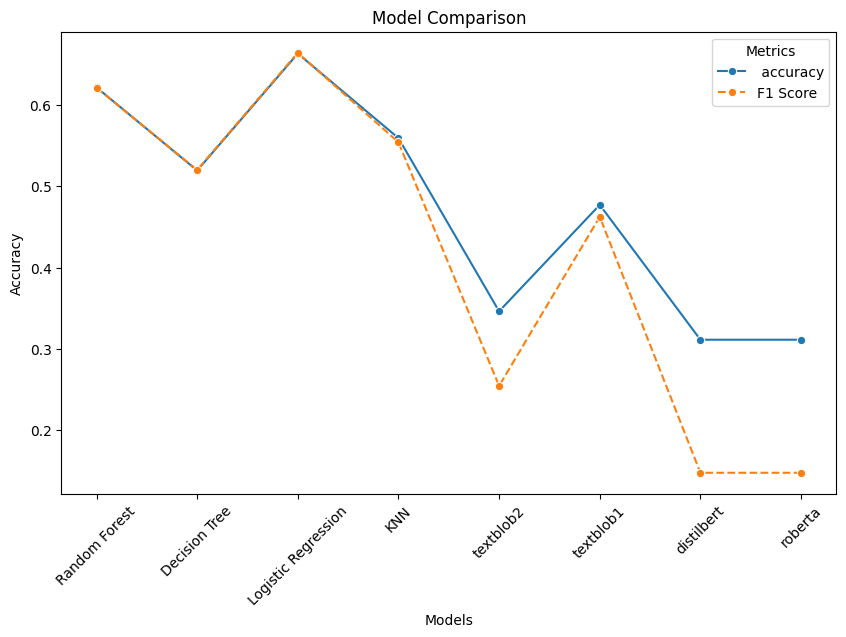

In [115]:
# Visualisation des résultats
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Random Forest": rf,
    "Decision Tree": dt,
    # "SVM": svm,
    "Logistic Regression": lr,
    "KNN": knn,
    "textblob2": TextBlob,
    "textblob1": Blobber,
    "distilbert" : distilled_student_sentiment_classifier,
    "roberta":classifier
}

# Visualisation des résultats
plt.figure(figsize=(10, 6))
# sns.barplot(x=list(models.keys()), y=accuracy)
sns.lineplot(x=list(models.keys()), y=accuracy, marker='o',label=' accuracy')
sns.lineplot(x=list(models.keys()), y=fscores, marker='o', linestyle='--', label='F1 Score')
plt.legend(title='Metrics')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# le meilleur model
best_model_index = np.argmax(accuracy)
best_model_name = list(models.keys())[best_model_index]
best_model_accuracy = accuracy[best_model_index]
print(f"Best model: {best_model_name} with accuracy: {best_model_accuracy:.4f}")
# le meilleur model
best_fscore_index = np.argmax(fscores)
best_fscore_name = list(models.keys())[best_fscore_index]
best_fscore = fscores[best_fscore_index]
print(f"Best model by F1 Score: {best_fscore_name} with F1 Score: {best_fscore:.4f}")

# save the model
import pickle
with open("../src/utils/bestmodel.pkl", "wb") as f:
    pickle.dump(rf, f)


# import joblib
# joblib.dump(rf, '../src/utils/bestmodel.pkl')
# # save the label encoder
# joblib.dump(label_encoder, 'label_encoder.pkl')
# # save the vectorizer
# joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
# # save the word2vec model
# joblib.dump(model_w2v, 'word2vec_model.pkl')

## matrice de fonsusion et learning curves

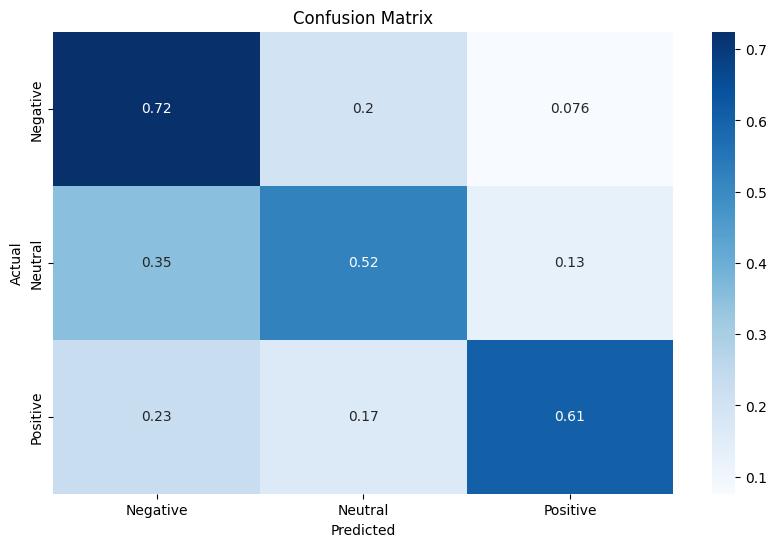

In [29]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_rf,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

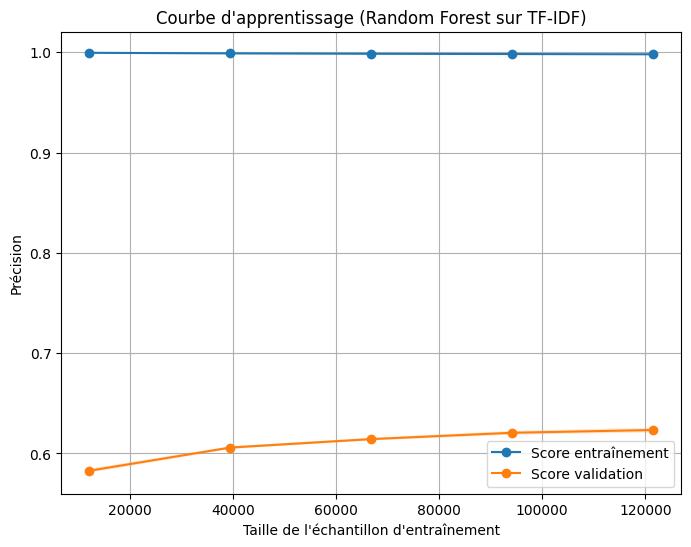

In [117]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    rf, x, y,
    cv=cv,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (Random Forest sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()

# under fitting

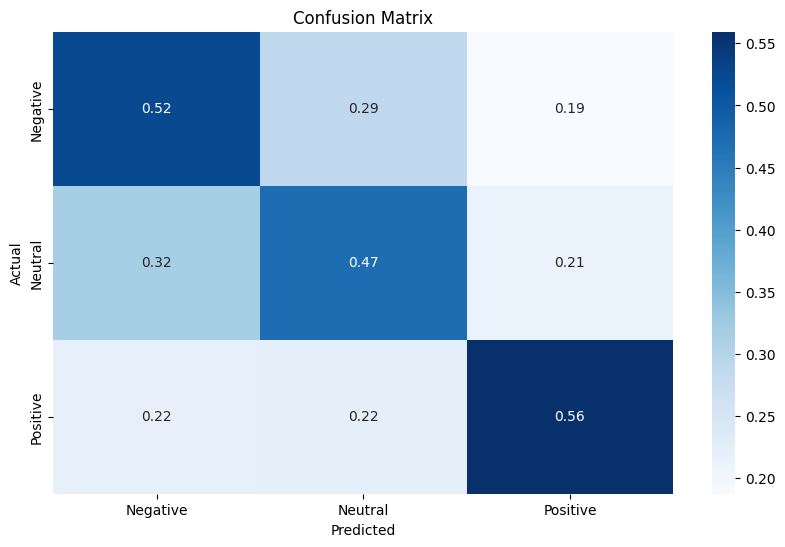

In [30]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_dt,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

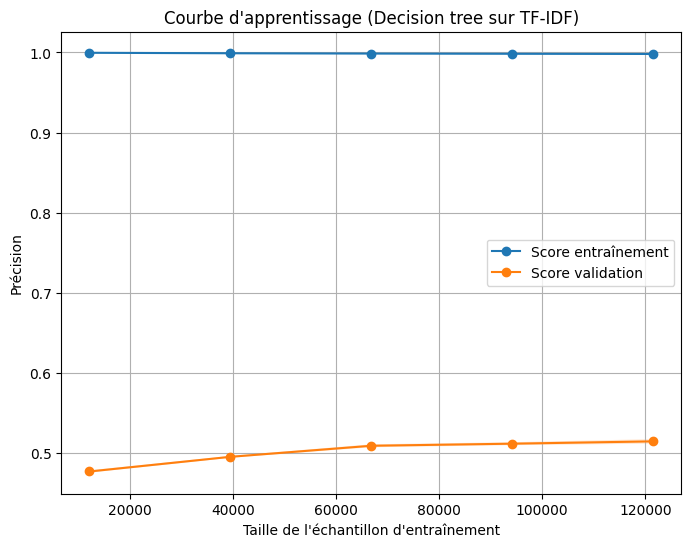

In [118]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    dt, x, y,
    cv=cv,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (Decision tree sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()

# under fitting 

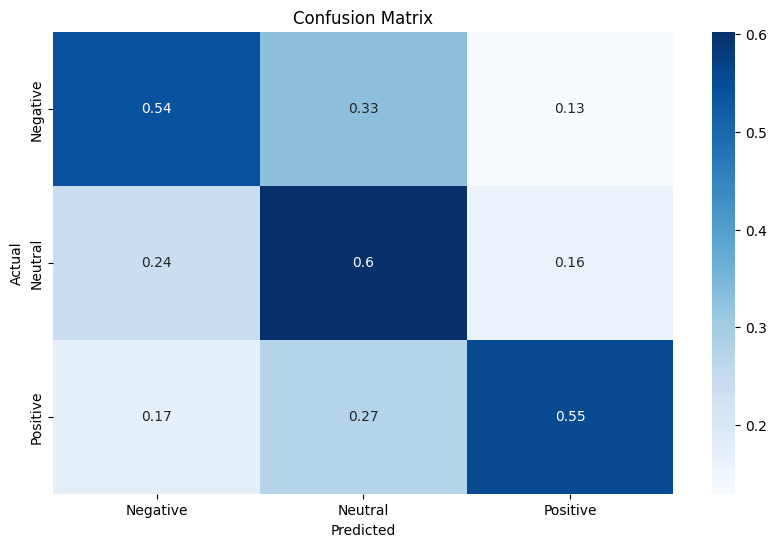

In [19]:
# Matrice de confusion
# import seaborn as sns
# conf_matrix = confusion_matrix(y_test, y_pred_svm,normalize='true' )
# plt.figure(figsize=(10, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

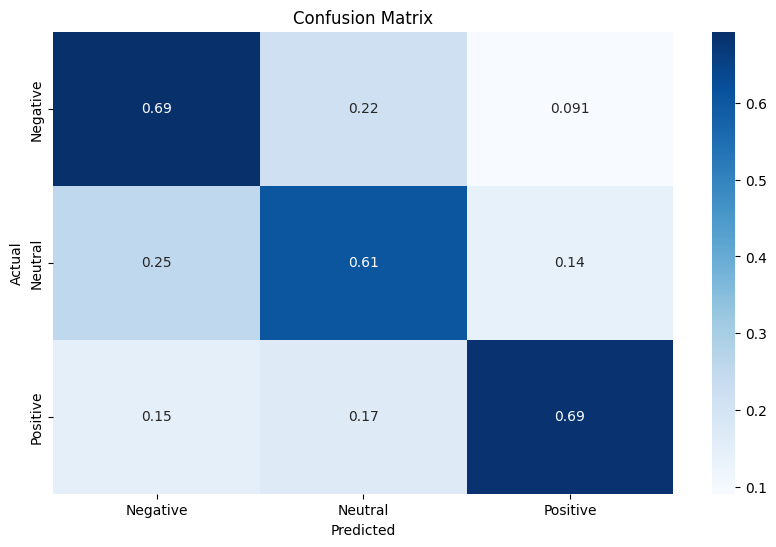

In [31]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_lr,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

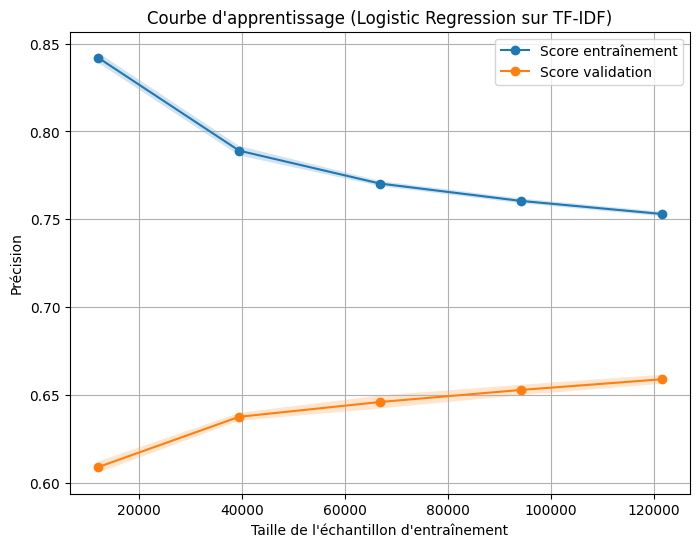

In [120]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    lr, x, y,
    cv=cv,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (Logistic Regression sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()

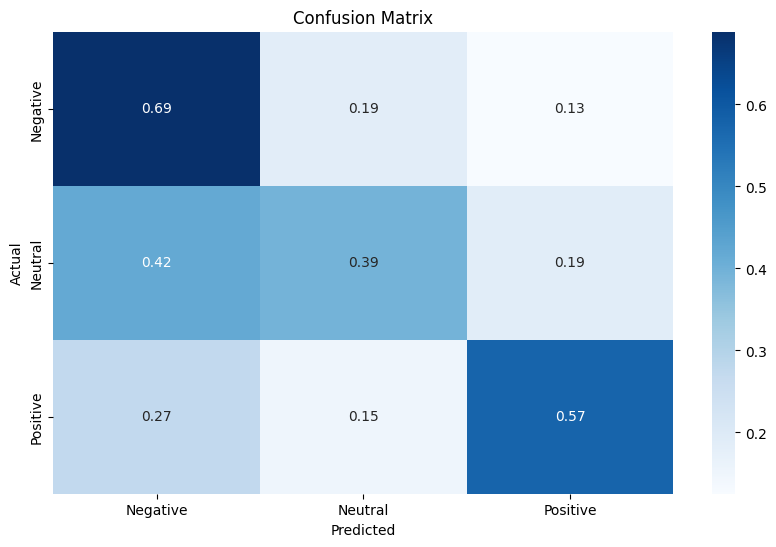

In [32]:
# Matrice de confusion
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_knn,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

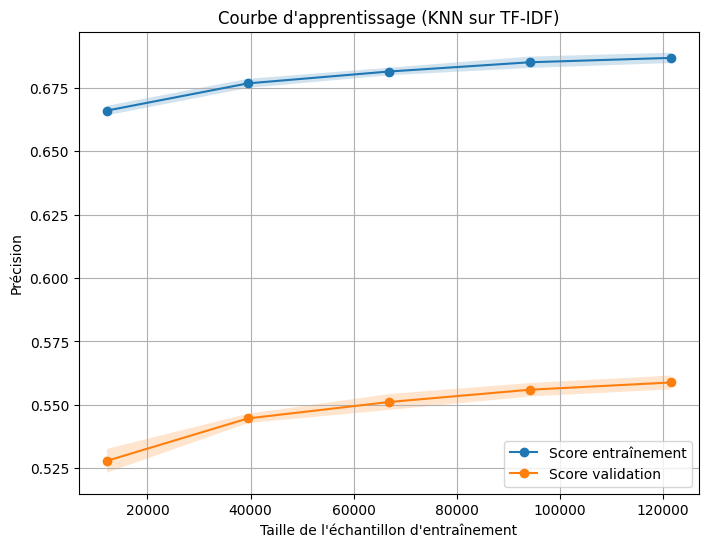

In [121]:

from sklearn.model_selection import learning_curve, ShuffleSplit
cv  = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    knn, x_knn, y,
    cv=cv,                 # 5-fold cross-validation
    scoring="accuracy",   # ou "f1_macro" si tes classes sont déséquilibrées
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)  # 10%, 25%, 50%, 75%, 100% des données
)

# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Score entraînement")
plt.plot(train_sizes, test_mean, 'o-', label="Score validation")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage (KNN sur TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()
# under fitting

# Amélioration

## Regression logistique

In [123]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "C": [0.01, 0.1, 1, 10],
    "fit_intercept" : [True, False],
    "class_weight" : [ None, "balanced"],
    "solver": ["lbfgs", "saga", "sag"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000, multi_class='multinomial'),
    param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid.fit(x_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Score CV associé :", grid.best_score_)

# best_model = grid.best_estimator_
# Meilleurs paramètres : {'C': 1, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
# Score CV associé : 0.6527239962405771

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Meilleurs paramètres : {'C': 1, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
Score CV associé : 0.6527239962405771


classification report 
               precision    recall  f1-score   support

           0       0.66      0.69      0.68     10850
           1       0.59      0.61      0.60      9462
           2       0.75      0.69      0.72     10065

    accuracy                           0.66     30377
   macro avg       0.67      0.66      0.66     30377
weighted avg       0.67      0.66      0.67     30377

l'accuracy : 0.6648780327221253
f1 score :  0.6658509679616358


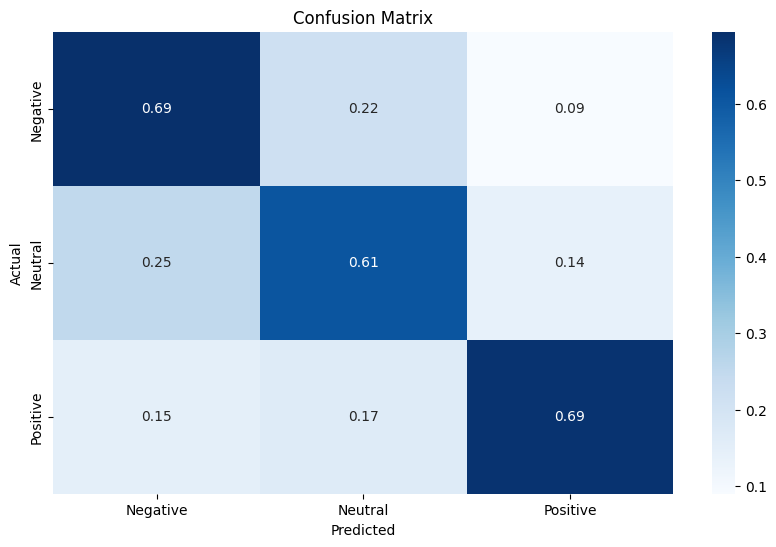

In [127]:
grid_model = grid.best_estimator_
y_grid = grid_model.predict(x_test)
# évaluation
print("classification report \n",classification_report(y_test, y_grid))
print("l'accuracy :",accuracy_score(y_test, y_grid))
print("f1 score : ",f1_score(y_test, y_grid, average="weighted"))

conf_matrix = confusion_matrix(y_test, y_grid,normalize='true' )
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Transformer : text blob

In [135]:
# text raw
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
predictions = []
for text in w_test:
    vs = tb(text).sentiment[0]
    if (vs > 0):
        predictions.append(2)#2
    elif (vs < 0):
        predictions.append(0)#0
    else:
        predictions.append(1)#1
y_pred_txtb = np.array(predictions)
# label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Adaptez selon vos labels
# if isinstance(y_test[0], (int, np.integer)):
#     y_pred_textb_mapped = [label_mapping.get(pred, 1) for pred in y_pred_txtb]
#     y_pred_txtb = np.array(y_pred_textb_mapped)

print(f"Classification Report:\n{classification_report(y_test, y_pred_txtb)}")
acc_textb = accuracy_score(y_test, y_pred_txtb)
#accuracy.append(acc_textb)
print(f"Accuracy: {acc_textb:.4f}")
fscore_textb = f1_score(y_test, y_pred_txtb, average='weighted')
#fscores.append(fscore_textb)
print(f"F1 Score: {fscore_textb:.4f}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.32      0.41     10850
           1       0.45      0.39      0.42      9462
           2       0.45      0.73      0.56     10065

    accuracy                           0.48     30377
   macro avg       0.50      0.48      0.46     30377
weighted avg       0.50      0.48      0.46     30377

Accuracy: 0.4773
F1 Score: 0.4625



## Roberta

### finetuning

In [ ]:
# Solution alternative : entraîner par chunks
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# 1. Préparer les données
mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_yt_trad["label"] = df_yt_trad["Sentiment"].map(mapping)

# 2. Charger le modèle pré-entraîné
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

device = torch.device("cpu")
model.to(device)
model.train()

# 3. Fonction d'entraînement par mini-batch manuel
def train_on_chunk(model, tokenizer, texts, labels, epochs=1, lr=2e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    for epoch in range(epochs):
        total_loss = 0
        for i, (text, label) in enumerate(zip(texts, labels)):
            # Tokeniser un exemple à la fois
            inputs = tokenizer(
                text, 
                truncation=True, 
                padding="max_length", 
                max_length=64, 
                return_tensors="pt"
            )
            
            # Forward pass
            outputs = model(**inputs, labels=torch.tensor([label]))
            loss = outputs.loss
            
            # Backward pass
            loss.backward()
            
            # Update tous les N exemples (gradient accumulation manuel)
            if (i + 1) % 32 == 0:
                optimizer.step()
                optimizer.zero_grad()
                
            total_loss += loss.item()
            
            if i % 1000 == 0:
                print(f"Chunk epoch {epoch}, example {i}, loss: {loss.item():.4f}")
        
        print(f"Epoch {epoch} terminée, loss moyenne: {total_loss/len(texts):.4f}")

# 4. Diviser en chunks et entraîner
chunk_size = 5000  # Ajustez selon votre mémoire
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_yt_trad["text_fr"].tolist(),
    df_yt_trad["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_yt_trad["label"]
)

print(f"Entraînement par chunks de {chunk_size} exemples...")
for i in range(0, len(train_texts), chunk_size):
    chunk_texts = train_texts[i:i+chunk_size]
    chunk_labels = train_labels[i:i+chunk_size]
    
    print(f"\nEntraînement chunk {i//chunk_size + 1}/{len(train_texts)//chunk_size + 1}")
    train_on_chunk(model, tokenizer, chunk_texts, chunk_labels, epochs=1)
    
    # Nettoyage mémoire entre chunks
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
# 5. Sauvegarder le modèle
output_dir = "./mon_modele_chunks"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Modèle sauvegardé dans {output_dir}")



Entraînement par chunks de 5000 exemples...

Entraînement chunk 1/25
Chunk epoch 0, example 0, loss: 0.0266
Chunk epoch 0, example 1000, loss: 1.1214
Chunk epoch 0, example 2000, loss: 0.1585
Chunk epoch 0, example 3000, loss: 1.1995
Chunk epoch 0, example 4000, loss: 0.7418
Epoch 0 terminée, loss moyenne: 0.8284

Entraînement chunk 2/25
Chunk epoch 0, example 0, loss: 1.1370
Chunk epoch 0, example 1000, loss: 2.0938
Chunk epoch 0, example 2000, loss: 0.9348
Chunk epoch 0, example 3000, loss: 0.2201
Chunk epoch 0, example 4000, loss: 0.1291
Epoch 0 terminée, loss moyenne: 0.7571

Entraînement chunk 3/25
Chunk epoch 0, example 0, loss: 2.4021
Chunk epoch 0, example 1000, loss: 1.3670
Chunk epoch 0, example 2000, loss: 1.6745
Chunk epoch 0, example 3000, loss: 0.1954
Chunk epoch 0, example 4000, loss: 0.6758
Epoch 0 terminée, loss moyenne: 0.7462

Entraînement chunk 4/25
Chunk epoch 0, example 0, loss: 2.5220
Chunk epoch 0, example 1000, loss: 0.2220
Chunk epoch 0, example 2000, loss: 0.

Device set to use cpu


Accuracy sur échantillon test: 0.3500
F1-score sur échantillon test: 0.1815
Entraînement par chunks terminé!


In [31]:
# 6. Tester le modèle
classifier = pipeline("sentiment-analysis", model=output_dir, device=-1)
test_sample = test_texts[:100]  # Tester sur 100 exemples
predictions = []

for text in test_sample:
    result = classifier(text)
    label = result[0]['label']
    # print(label)
    if label == 'positive':
        predictions.append(2)
    elif label == 'negative':
        predictions.append(0)
    else:
        predictions.append(1)

acc = accuracy_score(test_labels[:100], predictions)
f1 = f1_score(test_labels[:100], predictions, average='weighted')
print(f"Accuracy sur échantillon test: {acc:.4f}")
print(f"F1-score sur échantillon test: {f1:.4f}")

print("Entraînement par chunks terminé!")
# print(predictions)

Device set to use cpu


Accuracy sur échantillon test: 0.7400
F1-score sur échantillon test: 0.7321
Entraînement par chunks terminé!


### évaluation

In [32]:
output_dir = "./mon_modele_chunks"
classifier_custom = pipeline("sentiment-analysis", model=output_dir, device=-1, truncation=True,max_length=514)

print("Modèle fine-tuné chargé avec succès!")

Device set to use cpu


Modèle fine-tuné chargé avec succès!


In [33]:
from tqdm import tqdm

In [34]:
predictions = []
confidence_scores = []

# Prédiction avec barre de progression
for text in tqdm(w_test, desc="Prédictions"):
    try:
        result = classifier(text)
        label = result[0]['label']
        score = result[0]['score']
        
        # Mapper les labels du modèle vers nos classes
        if label == 'positive':
            predictions.append(2)  # Positif
        elif label == 'negative':
            predictions.append(0)  # Négatif  
        else:
            predictions.append(1)  # Neutre
            
        confidence_scores.append(score)
        
    except Exception as e:
        print(f"Erreur sur le texte: {text[:50]}... -> {e}")
        predictions.append(1)  # Défaut neutre
        confidence_scores.append(0.33)

predictions = np.array(predictions)

Prédictions:   1%|▏         | 389/30377 [00:17<17:27, 28.62it/s] 

Erreur sur le texte: William Barr is no more than worthless piece of cr... -> The expanded size of the tensor (536) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 536].  Tensor sizes: [1, 514]


Prédictions:   3%|▎         | 1059/30377 [00:42<17:50, 27.38it/s]

Erreur sur le texte: Jusqu'à présent. Hé Andrew, ça ne sonne pas si gén... -> The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]


Prédictions:   9%|▉         | 2751/30377 [01:46<16:38, 27.66it/s]

Erreur sur le texte: Directeur de l'Institut Hudson Shea: Je ne crois p... -> The expanded size of the tensor (763) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 763].  Tensor sizes: [1, 514]


Prédictions:  10%|▉         | 2957/30377 [01:54<14:50, 30.81it/s]

Erreur sur le texte: 𝗥𝘂𝘀𝘀𝗶𝗮-𝗨𝗸𝗿𝗮𝗶𝗻𝗲 𝗪𝗮𝗿: 𝗧𝗵𝗲 𝗣𝗮𝗻𝗱𝗼𝗿𝗮 𝗕𝗼𝘅 𝗶𝘀 𝗶𝘀 𝗢𝗽𝗲𝗻 Les... -> The expanded size of the tensor (726) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 726].  Tensor sizes: [1, 514]


Prédictions:  21%|██        | 6272/30377 [04:00<14:55, 26.92it/s]

Erreur sur le texte: Il est déjà impossible pour les États-Unis de cont... -> The expanded size of the tensor (588) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 588].  Tensor sizes: [1, 514]


Prédictions:  35%|███▌      | 10717/30377 [06:50<10:36, 30.87it/s]

Erreur sur le texte: Écrire ceci comme quelqu'un qui a échangé sur FF14... -> The expanded size of the tensor (522) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 522].  Tensor sizes: [1, 514]


Prédictions:  39%|███▉      | 11827/30377 [07:36<12:28, 24.77it/s]

Erreur sur le texte: Angular 4: CheatSheet # Read var From TypeScript: ... -> The expanded size of the tensor (562) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 562].  Tensor sizes: [1, 514]


Prédictions:  40%|████      | 12196/30377 [07:49<10:27, 28.97it/s]

Erreur sur le texte: Passer une lettre d'un compatriote: un cri d'espri... -> The expanded size of the tensor (942) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 942].  Tensor sizes: [1, 514]


Prédictions:  45%|████▌     | 13703/30377 [08:44<09:27, 29.40it/s]

Erreur sur le texte: FYI: Pour ceux qui ne comprennent pas, voici l'exp... -> The expanded size of the tensor (716) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 716].  Tensor sizes: [1, 514]


Prédictions:  57%|█████▋    | 17369/30377 [11:04<07:36, 28.51it/s]

Erreur sur le texte: La voiture de sécurité du GP australien termine un... -> The expanded size of the tensor (893) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 893].  Tensor sizes: [1, 514]


Prédictions:  58%|█████▊    | 17716/30377 [11:16<07:01, 30.04it/s]

Erreur sur le texte: Ma fonctionnalité de souhaits: 1) Saisons - Je sou... -> The expanded size of the tensor (613) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 613].  Tensor sizes: [1, 514]


Prédictions:  65%|██████▌   | 19860/30377 [12:38<05:53, 29.72it/s]

Erreur sur le texte: Harry Bhaiya, veuillez créer une courte série vidé... -> The expanded size of the tensor (590) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 590].  Tensor sizes: [1, 514]


Prédictions:  68%|██████▊   | 20786/30377 [13:11<05:04, 31.52it/s]

Erreur sur le texte: Est-ce que cela est une surprise, trop civilisé, t... -> The expanded size of the tensor (574) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 574].  Tensor sizes: [1, 514]


Prédictions:  70%|███████   | 21275/30377 [13:28<04:40, 32.40it/s]

Erreur sur le texte: Je suis tellement bizarre des conneries de la merd... -> The expanded size of the tensor (559) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 559].  Tensor sizes: [1, 514]


Prédictions:  72%|███████▏  | 21923/30377 [13:52<04:47, 29.41it/s]

Erreur sur le texte: Il y a 4 améliorations peuvent être apportées. 1) ... -> The expanded size of the tensor (1063) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1063].  Tensor sizes: [1, 514]


Prédictions:  76%|███████▌  | 23132/30377 [14:36<03:59, 30.28it/s]

Erreur sur le texte: Jésus parle de l'amour, de la compassion et de l'h... -> The expanded size of the tensor (1164) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1164].  Tensor sizes: [1, 514]


Prédictions:  79%|███████▊  | 23919/30377 [15:05<03:42, 28.96it/s]

Erreur sur le texte: Ainsi, à mon avis, la programmation procédurale es... -> The expanded size of the tensor (805) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 805].  Tensor sizes: [1, 514]


Prédictions:  81%|████████▏ | 24719/30377 [15:34<03:19, 28.43it/s]

Erreur sur le texte: Scandinave ici. À l'insu de la plupart des gens de... -> The expanded size of the tensor (733) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 733].  Tensor sizes: [1, 514]


Prédictions:  84%|████████▍ | 25621/30377 [16:08<02:37, 30.20it/s]

Erreur sur le texte: Je n'ai jamais vu vos vidéos auparavant, mais c'es... -> The expanded size of the tensor (764) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 764].  Tensor sizes: [1, 514]
Erreur sur le texte: Hey Dan! J'ai une recommandation pour vous car vou... -> The expanded size of the tensor (561) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 561].  Tensor sizes: [1, 514]


Prédictions:  86%|████████▋ | 26270/30377 [16:32<02:15, 30.27it/s]

Erreur sur le texte: Merci pour vore Vidéo d'Information. Lorsque Dolan... -> The expanded size of the tensor (625) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 625].  Tensor sizes: [1, 514]


Prédictions:  89%|████████▊ | 26910/30377 [16:56<02:19, 24.81it/s]

Erreur sur le texte: 7 février - Interview avec Bob Woodward: ""C'est m... -> The expanded size of the tensor (1080) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1080].  Tensor sizes: [1, 514]


Prédictions:  89%|████████▉ | 27117/30377 [17:04<01:48, 29.91it/s]

Erreur sur le texte: Ils ont besoin de prison! Ce n'est pas du tout une... -> The expanded size of the tensor (749) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 749].  Tensor sizes: [1, 514]


Prédictions:  94%|█████████▍| 28657/30377 [17:59<00:54, 31.68it/s]

Erreur sur le texte: L'Amérique est devenue du jour au lendemain de la ... -> The expanded size of the tensor (552) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 552].  Tensor sizes: [1, 514]


Prédictions:  95%|█████████▍| 28798/30377 [18:04<00:51, 30.50it/s]

Erreur sur le texte: Ayant mené de nombreuses entrevues de questions de... -> The expanded size of the tensor (705) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 705].  Tensor sizes: [1, 514]


Prédictions:  96%|█████████▋| 29282/30377 [18:22<00:36, 29.84it/s]

Erreur sur le texte: En tant qu'Irlandais, je suis totalement contre la... -> The expanded size of the tensor (653) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 653].  Tensor sizes: [1, 514]


Prédictions:  97%|█████████▋| 29398/30377 [18:26<00:32, 30.02it/s]

Erreur sur le texte: La Constitution stipule également que la «milice» ... -> The expanded size of the tensor (580) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 580].  Tensor sizes: [1, 514]


Prédictions:  98%|█████████▊| 29629/30377 [18:34<00:25, 28.99it/s]

Erreur sur le texte: Nahum 1: 2 Le Seigneur est un Dieu jaloux et venge... -> The expanded size of the tensor (590) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 590].  Tensor sizes: [1, 514]


Prédictions:  98%|█████████▊| 29734/30377 [18:38<00:23, 27.31it/s]

Erreur sur le texte: Tout d'abord, MongoDB! = NOSQL. MongoDB relève du ... -> The expanded size of the tensor (704) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 704].  Tensor sizes: [1, 514]


Prédictions: 100%|██████████| 30377/30377 [19:01<00:00, 26.60it/s]


RÉSULTATS D'ÉVALUATION DU MODÈLE FINE-TUNÉ
Accuracy: 0.7574
F1-Score (weighted): 0.7551
F1-Score (macro): 0.7528
Confiance moyenne: 0.7544

Rapport détaillé par classe:
              precision    recall  f1-score   support

     Négatif       0.72      0.85      0.78     10850
      Neutre       0.74      0.63      0.68      9462
     Positif       0.82      0.79      0.80     10065

    accuracy                           0.76     30377
   macro avg       0.76      0.75      0.75     30377
weighted avg       0.76      0.76      0.76     30377



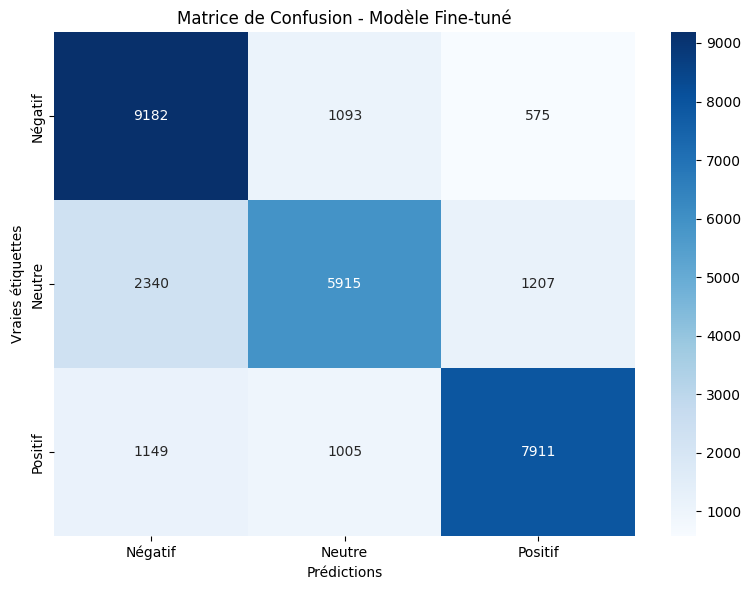

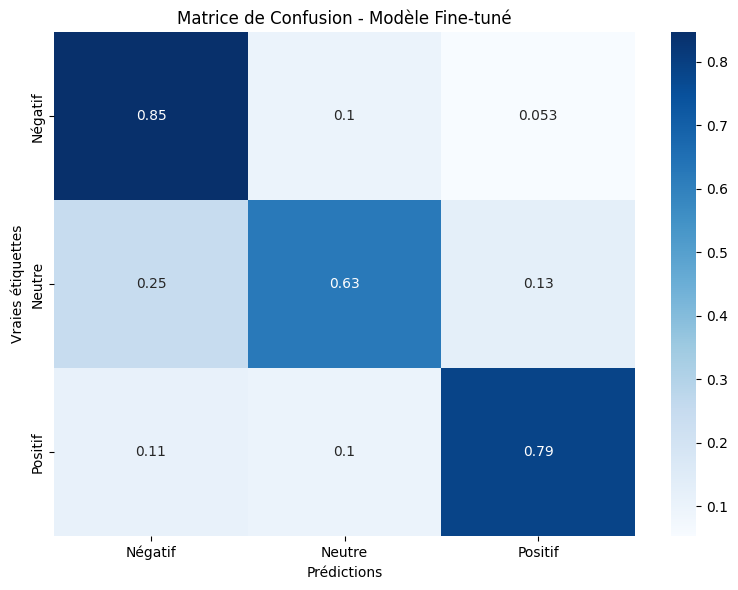

: 

In [38]:
# Calcul des métriques
accuracy = accuracy_score(y_test, predictions)
f1_weighted = f1_score(y_test, predictions, average='weighted')
f1_macro = f1_score(y_test, predictions, average='macro')

# Rapport de classification détaillé
target_names = ['Négatif', 'Neutre', 'Positif']
report = classification_report(
    y_test, 
    predictions, 
    target_names=target_names,
    output_dict=True
)

print("=" * 60)
print("RÉSULTATS D'ÉVALUATION DU MODÈLE FINE-TUNÉ")
print("=" * 60)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"Confiance moyenne: {np.mean(confidence_scores):.4f}")
print("\nRapport détaillé par classe:")
print(classification_report(y_test, predictions, target_names=target_names))

# Matrice de confusion
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Modèle Fine-tuné')
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.tight_layout()
plt.show()

# Matrice de confusion
cm = confusion_matrix(y_test, predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Modèle Fine-tuné')
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.tight_layout()
plt.show()


In [50]:
import torch
import os
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    pipeline
)
from datasets import Dataset
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

# 0. Configuration environnement pour MPS
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

# 1. Configuration mémoire ultra-agressive
def cleanup_memory():
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    gc.collect()  # Double nettoyage

# 2. Échantillonner vos données pour test (optionnel)
# Si vous voulez d'abord tester avec un sous-ensemble
# df_sample = df_yt_trad.sample(n=10000, random_state=42)  # Commencer petit
# df_yt_trad = df_sample  # Décommentez ces lignes pour tester

# Vos données existantes
mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_yt_trad["label"] = df_yt_trad["Sentiment"].map(mapping)

print(f"Taille du dataset: {len(df_yt_trad)}")
print(f"Distribution des labels: {df_yt_trad['label'].value_counts()}")

# 3. Split avec sklearn
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_yt_trad["text_fr"].tolist(),
    df_yt_trad["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_yt_trad["label"]
)

print(f"Train: {len(train_texts)}, Test: {len(test_texts)}")

# 4. Charger modèle et tokenizer
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Charger le modèle directement sur CPU d'abord
print("Chargement du modèle...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=3,
    torch_dtype=torch.float32,  # Utiliser float32 au lieu de float16
)

# Optimisations mémoire ultra-agressives
model.gradient_checkpointing_enable()

# Forcer CPU si MPS pose problème
device = torch.device("cpu")  # Commencer par CPU
print(f"Device utilisé: {device}")
model.to(device)

cleanup_memory()

# 5. Tokenisation avec longueur réduite
def tokenize_function(examples):
    return tokenizer(
        examples["text_fr"], 
        truncation=True, 
        padding="max_length", 
        max_length=64  # Réduire drastiquement à 64 tokens
    )

# Créer de très petits datasets pour la tokenisation
print("Création des datasets...")
train_df = pd.DataFrame({"text_fr": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text_fr": test_texts, "label": test_labels})

# Traiter par très petits chunks
def create_tokenized_dataset(df, chunk_size=500):
    all_tokenized = []
    for i in range(0, len(df), chunk_size):
        chunk_df = df.iloc[i:i+chunk_size]
        chunk_dataset = Dataset.from_pandas(chunk_df)
        
        tokenized_chunk = chunk_dataset.map(
            tokenize_function,
            batched=True,
            batch_size=100,
            remove_columns=["text_fr"]
        )
        
        all_tokenized.append(tokenized_chunk)
        cleanup_memory()
        
        if i % 5000 == 0:
            print(f"Traité {i}/{len(df)} exemples...")
    
    # Concaténer tous les chunks
    from datasets import concatenate_datasets
    return concatenate_datasets(all_tokenized)

print("Tokenisation train...")
tokenized_train = create_tokenized_dataset(train_df)
cleanup_memory()

print("Tokenisation test...")
tokenized_test = create_tokenized_dataset(test_df)
cleanup_memory()

# Format PyTorch
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

print(f"Tokenisation terminée. Train: {len(tokenized_train)}, Test: {len(tokenized_test)}")

# 6. Fonction de métriques
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# 7. Arguments d'entraînement ultra-conservateurs
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,  # Une seule époque pour commencer
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,  # Augmenter pour compenser
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=5000,
    eval_strategy="steps",
    eval_steps=5000,
    save_total_limit=1,
    load_best_model_at_end=False,  # Désactiver pour économiser mémoire
    fp16=False,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=True,
    report_to="none",
    prediction_loss_only=True,  # Simplifier les calculs
    max_grad_norm=1.0,
)

# 8. Créer le trainer
print("Création du trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
)

cleanup_memory()

# 9. Entraîner le modèle avec gestion d'erreur avancée
print("Début de l'entraînement...")
try:
    trainer.train()
    print("Entraînement terminé avec succès !")
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print(f"Erreur mémoire: {e}")
        print("\nSolutions à essayer:")
        print("1. Réduire max_length à 32 tokens")
        print("2. Augmenter gradient_accumulation_steps à 64")
        print("3. Utiliser un sous-ensemble des données pour tester")
        print("4. Entraîner par chunks plus petits")
        
        # Essayer de sauvegarder quand même le modèle actuel
        try:
            model.save_pretrained("./modele_partiel")
            tokenizer.save_pretrained("./modele_partiel")
            print("Modèle partiel sauvegardé dans ./modele_partiel")
        except:
            pass
    raise e

# 10. Sauvegarder le modèle
output_dir = "./mon_modele_sentiment_final"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Modèle sauvegardé dans {output_dir}")

cleanup_memory()

# 11. Évaluation avec gestion mémoire
print("Évaluation finale...")
try:
    eval_results = trainer.evaluate()
    print("Résultats d'évaluation:")
    for key, value in eval_results.items():
        print(f"{key}: {value:.4f}")
except RuntimeError as e:
    print(f"Évaluation échouée (mémoire): {e}")
    print("Modèle sauvegardé mais évaluation impossible")

cleanup_memory()

print("Script terminé!")
print(f"Modèle disponible dans: {output_dir}")

# Instructions pour utiliser le modèle
print("\nPour utiliser votre modèle:")
print(f'''
classifier = pipeline(
    "sentiment-analysis", 
    model="{output_dir}",
    device=-1  # CPU
)
result = classifier("Votre texte ici")
print(result)
''')

Taille du dataset: 151884
Distribution des labels: label
0    53977
2    50111
1    47796
Name: count, dtype: int64
Train: 121507, Test: 30377
Chargement du modèle...
Device utilisé: cpu
Création des datasets...
Tokenisation train...


Map: 100%|██████████| 500/500 [00:00<00:00, 20255.10 examples/s]

Traité 0/121507 exemples...



Map: 100%|██████████| 500/500 [00:00<00:00, 23863.00 examples/s]


Traité 5000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 20628.67 examples/s]


Traité 10000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 21316.64 examples/s]


Traité 15000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24194.46 examples/s]


Traité 20000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 14482.69 examples/s]


Traité 25000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24522.93 examples/s]


Traité 30000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 21131.91 examples/s]


Traité 35000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 23499.87 examples/s]


Traité 40000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 23828.56 examples/s]


Traité 45000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 13153.98 examples/s]


Traité 50000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 25026.28 examples/s]


Traité 55000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 25545.43 examples/s]


Traité 60000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 21469.18 examples/s]


Traité 65000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24053.49 examples/s]


Traité 70000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24256.59 examples/s]


Traité 75000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 22487.88 examples/s]


Traité 80000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 21522.94 examples/s]


Traité 85000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24773.22 examples/s]


Traité 90000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 25364.07 examples/s]


Traité 95000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 25379.42 examples/s]


Traité 100000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 23542.61 examples/s]


Traité 105000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24380.67 examples/s]


Traité 110000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 23954.31 examples/s]


Traité 115000/121507 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 23807.19 examples/s]


Traité 120000/121507 exemples...


Map: 100%|██████████| 7/7 [00:00<00:00, 3340.17 examples/s]


Tokenisation test...


Map: 100%|██████████| 500/500 [00:00<00:00, 20081.89 examples/s]

Traité 0/30377 exemples...



Map: 100%|██████████| 500/500 [00:00<00:00, 22311.55 examples/s]


Traité 5000/30377 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 25502.56 examples/s]


Traité 10000/30377 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24265.85 examples/s]


Traité 15000/30377 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 24909.16 examples/s]


Traité 20000/30377 exemples...


Map: 100%|██████████| 500/500 [00:00<00:00, 20727.15 examples/s]


Traité 25000/30377 exemples...


Map: 100%|██████████| 377/377 [00:00<00:00, 21920.13 examples/s]


Traité 30000/30377 exemples...
Tokenisation terminée. Train: 121507, Test: 30377
Création du trainer...


/var/folders/x7/nvdtqwsn1m31qvsf2ntlrwtw0000gn/T/ipykernel_2387/3238638263.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


RuntimeError: MPS backend out of memory (MPS allocated: 5.23 GB, other allocations: 12.91 GB, max allowed: 18.13 GB). Tried to allocate 3.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Vader

In [59]:
print(f"les shapes des données d'entraînement et de test: {w_train.shape}, {w_test.shape}")

les shapes des données d'entraînement et de test: (121507,), (30377,)


In [101]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator

analyzer = SentimentIntensityAnalyzer() #lexicon_file="/Users/carla/Desktop/GitHub/Projet-RNCP/data/vader_lexicon.txt"
analyzer.translate = False
def getSentiment(phrase):
    txt = GoogleTranslator(source='fr', target='en').translate(phrase)
    print(txt)
    s = analyzer.polarity_scores(txt)
    print(s)
    if s['compound'] <= -0.05:
        sentiment = 0
    elif s['compound'] >= 0.05:
        sentiment = 1
    else:
        sentiment = 2
    return sentiment

getSentiment("Tout le monde en parle comme si ça ne pouvait pas être arrêté Et la garde nationale et les fusils Dis juste non")


Everyone talks about it as if it couldn't be stopped and the national guard and the rifles say just no


IndexError: list index out of range

In [94]:
# import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer() #lexicon_file="/Users/carla/Desktop/GitHub/Projet-RNCP/data/vader_lexicon.txt"
analyzer.translate = True
def getSentiment(phrase):
    txt = re.sub(r"([?.!,])", r" \1 ", phrase)
    txt = re.sub(r"non", r" \1 ", phrase)
    s = analyzer.polarity_scores(txt)
    print(s)
    if s['compound'] <= -0.05:
        sentiment = 0
    elif s['compound'] >= 0.05:
        sentiment = 1
    else:
        sentiment = 2
    return sentiment

predictions_vader = []
for text in w_test:
    sentiment = getSentiment(text)
    # print(sentiment)
    if sentiment == 2:
        predictions_vader.append(2) # positive
    elif sentiment == 0:
        predictions_vader.append(0)
    elif sentiment == 1:
        predictions_vader.append(1)
    else:
        predictions_vader.append(1)

y_pred_vader = np.array(predictions_vader)

print(y_pred_vader)
print("RÉSULTATS vader:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_vader)}")
acc_vader = accuracy_score(y_test, y_pred_vader)
#accuracy.append(acc_vader)
print(f"Accuracy: {acc_vader:.4f}")
fscore_vader = f1_score(y_test, y_pred_vader, average='weighted')
#fscores.append(fscore_vader)
print(f"F1 Score: {fscore_vader:.4f}\n")

{'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'compound': 0.3612}
{'neg': 0.15, 'neu': 0.551, 'pos': 0.299, 'compound': 0.4404}
{'neg': 0.228, 'neu': 0.772, 'pos': 0.0, 'compound': -0.7783}
{'neg': 0.198, 'neu': 0.509, 'pos': 0.293, 'compound': 0.1759}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.125, 'neu': 0.796, 'pos': 0.08, 'compound': -0.3182}
{'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.8625}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.6696}
{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.128}
{'neg': 0.049, 'neu': 0.887, 'pos': 0.064, 'compound': 0.1779}
{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.8037}
{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.6476}
{'neg': 0.098, 'neu': 0.902, 'pos': 0.0, 'compound': -0.4023}
{'neg': 0.142, 'neu': 0.623, 'pos': 0.236, 'compound': 0.3947}
{'neg': 0.0, 'neu': 0.671, '

IndexError: list index out of range

In [82]:
for i,text in enumerate(w_test):
    print(text, i)
    
    getSentiment(text)

J'aime et je vais faire des commentaires pour les commentaires, préparez-vous à revenir en arrière 0
{'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'compound': 0.3612}
Il a tiré l'outil 😂 1
{'neg': 0.15, 'neu': 0.551, 'pos': 0.299, 'compound': 0.4404}
La dépression des électeurs s'est produite au Texas où les habitants des quartiers minoritaires pauvres ont dû attendre environ 7 heures pour voter mardi. 2
{'neg': 0.228, 'neu': 0.772, 'pos': 0.0, 'compound': -0.7783}
Howard vous l'avez dans le cul? LOL bien pour vous! 3
{'neg': 0.198, 'neu': 0.509, 'pos': 0.293, 'compound': 0.1759}
Bonjour5 4
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
J'étais curieux de savoir ce qu'il nous montrera à l'instant où il a montré un poignard que je savais qu'il était plein de merde 5
{'neg': 0.125, 'neu': 0.796, 'pos': 0.08, 'compound': -0.3182}
Vous êtes trop bon mir🙂 merci d'avoir partagé vos connaissances 👍🙏 6
{'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.8625}
Utilisez-vous Iterm2, si oui 

IndexError: list index out of range

In [1]:
readSentiment = SentimentIntensityAnalyzer()
# df_train['vader_sentiment'] = df_train['text'].apply(lambda x: readSentiment.polarity_scores(x)['compound'])

NameError: name 'SentimentIntensityAnalyzer' is not defined

In [158]:
def getSentiment(phrase):
    s = readSentiment.polarity_scores(phrase)
    if s['compound'] <= -0.05:
        sentiment = 0
    elif s['compound'] >= 0.05:
        sentiment = 1
    else:
        sentiment = 2
    return sentiment, s

In [162]:
sentiments = ['Negative', 'Positive', 'Neutral']
score=0
for index, row in df_train.iterrows():
    txt = row['text']
    label = row['label']
    pred = readSentiment.polarity_scores(txt)
    sent = sentiments[getSentiment(txt)[0]]
    # print( index,"\n",txt,"\n",label,"\n", pred,"\n",sent,"\n_____________")
    if sent == label:
        score += 1
print("Score: ", score, "/", len(df_sample), "=", score/len(df_sample)*100, "%")

IndexError: list index out of range

In [160]:
sentiments = ['Negative', 'Positive', 'Neutral']
score=0
for index, row in df_fr.iterrows():
    txt = row['text_fr']
    label = row['Sentiment']
    pred = readSentiment.polarity_scores(txt)
    sent = sentiments[getSentiment(txt)[0]]
    # print( index,"\n",txt,"\n",label,"\n", pred,"\n",sent,"\n_____________")
    if sent == label:
        score += 1
print("Score: ", score, "/", len(df_sample), "=", score/len(df_sample)*100, "%")

HTTPError: HTTP Error 500: Internal Server Error

# Text blob

In [22]:

# blob1 = tb(u"Quelle belle matinée")
# print(blob1.sentiment)

# blob2 = tb(u"C'est une voiture terribles.")
# print(blob2.sentiment)

# print(blob1.analyzer is blob2.analyzer)


In [23]:
# text raw
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
for i in df['comment'][:10]:
    print(i)
    print(tb(i).sentiment)
    print(tb(i).sentiment[0])  # Affiche la polarité entre -1 et 1
    print(tb(i).sentiment[1])  # Affiche la subjectivité entre 0 et 1
    vs = tb(i).sentiment[0]
    if (vs > 0):
        print('Positive')
    elif (vs < 0):
        print('Negative')
    else:
        print('Neutral')
    print("\n")

Merci à Odoo le sponsor cette vidéo ! Pour découvrir Odoo, clique juste ici : https://www.odoo.com/r/cAlx

Bonne découverte ou redécouverte à tous ! (et allez écouter Childish, c'est important)

bises 🙏
(0.31, 0.25000000000000006)
0.31
0.25000000000000006
Positive


Fait une vidéo sur Tyler the creator stp
(0.0, 0.0)
0.0
0.0
Neutral


Lol le disclaimer😂
(0.0, 0.0)
0.0
0.0
Neutral


où peut-on voir la série "Earn and Alfred" ???
(0.0, 0.0)
0.0
0.0
Neutral


C'est pas un re upload ? Impression de déjà vu (pas une critique foireuse, juste impression de déjà vu de fou)
(0.06999999999999999, 0.6166666666666667)
0.06999999999999999
0.6166666666666667
Positive


fais une vidéo sur tyler the creator stpppppppp
(0.0, 0.0)
0.0
0.0
Neutral


C est pas SEB c est un robot 😅😅😅
(0.0, 0.0)
0.0
0.0
Neutral


Super vidéo comme d’hab, mais je trouve comme souvent que c’est trop individualiste. Il arrive à tout faire aussi en grande partie parce que à chaque fois il est entouré des bonnes personnes qui so

In [24]:
# # text clean
# tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
# for i in df['comment_clean_lem'][:10]:
#     print(i)
#     print(tb(i).sentiment)
#     print(tb(i).sentiment[0])  # Affiche la polarité entre -1 et 1
#     print(tb(i).sentiment[1])  # Affiche la subjectivité entre 0 et 1
#     vs = tb(i).sentiment[0]
#     if (vs > 0):
#         print('Positive')
#     elif (vs < 0):
#         print('Negative')
#     else:
#         print('Neutral')
#     print("\n")

odoo sponsor decouvrir odoo clique decouverte redecouvrir aller ecouter childish important bise
(0.20000000000000004, 0.18333333333333335)
0.20000000000000004
0.18333333333333335
Positive


video_sur tyler_the_creator
(0.0, 0.0)
0.0
0.0
Neutral


mort_de_rire disclaimer
(0.0, 0.0)
0.0
0.0
Neutral


voir serie earn alfred
(0.0, 0.0)
0.0
0.0
Neutral


reupload impression deja_vu critique foireux impression deja_vu
(0.0, 0.75)
0.0
0.75
Neutral


video_sur tyler_the_creator stp
(0.0, 0.0)
0.0
0.0
Neutral


robot
(0.0, 0.0)
0.0
0.0
Neutral


super habitude trouver trop individualiste arriver grand partie fois entourer personne specialiser domaine
(0.25, 0.6)
0.25
0.6
Positive


coiffure rasage deranger monde contre gresillement sortie fois immersion
(0.0, 0.0)
0.0
0.0
Neutral


super vraiment contre faillir taper tete contre fois prononcer childish
(0.35, 0.7)
0.35
0.7
Positive




In [45]:
# # text clean
# score = 0
# tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
# for index, i in enumerate(df_sample['text_fr']):
#     #print(i)
#     #print(tb(i).sentiment)
#     #print(tb(i).sentiment[0])  # Affiche la polarité entre -1 et 1
#     #print(tb(i).sentiment[1])  # Affiche la subjectivité entre 0 et 1
#     vs = tb(i).sentiment[0]
#     sent = df_sample['Sentiment'].iloc[index]
#     if (vs > 0):
#         #print('Positive')
#         label = 'Positive'
#     elif (vs < 0):
#         #print('Negative')
#         label = 'Negative'
#     else:
#         #print('Neutral')
#         label = 'Neutral'
#     if label == sent:
#         score += 1
#     #print("\n______________________________________________")
# print("Score: ", score, "/", 1000, "=", score/1000*100, "%")

Score:  471 / 1000 = 47.099999999999994 %


# Emotion English DistilRoBERTa-base

In [32]:
from transformers import pipeline
classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores=True,
    max_length=531)

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
def get_sentiment(text : str, classifier, all=False ) -> str:
    res = classifier(text)[0]
    max_result = max(res, key=lambda x: x['score'])
    if all == True :
        return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
    else:
        return max_result['label']

for i in df_fr['text_fr'][:10]:
    print(i)
    print(get_sentiment(i, classifier=classifier))
    print("\n")

NameError: name 'df_fr' is not defined

In [33]:
for i in df['comment_clean_lem'][:10]:
    print(i)
    print(get_sentiment(i, classifier=classifier))
    print("\n")


odoo sponsor decouvrir odoo clique decouverte redecouvrir aller ecouter childish important bise
neutral


video_sur tyler_the_creator
joy


mort_de_rire disclaimer
neutral


voir serie earn alfred
neutral


reupload impression deja_vu critique foireux impression deja_vu
neutral


video_sur tyler_the_creator stp
joy


robot
neutral


super habitude trouver trop individualiste arriver grand partie fois entourer personne specialiser domaine
neutral


coiffure rasage deranger monde contre gresillement sortie fois immersion
neutral


super vraiment contre faillir taper tete contre fois prononcer childish
anger




In [42]:
for index, i in enumerate(df_sample['text_fr']):
    print(i)
    print(get_sentiment(i, classifier=classifier))
    print("\n")


Cette vidéo était assez difficile à suivre et à comprendre.
disgust


Aimez votre spectacle et appréciez votre plateforme courageuse. Nous vous remercions.
fear


quel thème de couleur utilisez-vous S'il vous plaît me dire
fear


Celui qui s'inquiète de tout ce qu'ils ont fait... Mais !!! Si quelqu'un d'autre fait la même chose... alors et alors seulement c'est maintenant un crime !!! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

RuntimeError: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]

# distilbert-base-multilingual-cased-sentiments-student

In [106]:
from transformers import pipeline
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True, max_length=512, 
)
def get_sentiment(text : str, classifier, all=False ) -> str:
    res = classifier(text)[0]
    max_result = max(res, key=lambda x: x['score'])
    if all == True :
        return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
    else:
        return max_result['label']


Device set to use mps:0
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [109]:
from transformers import pipeline
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True, max_length=512, 
)
def get_sentiment(text : str, classifier, all=False ) -> str:
    res = classifier(text)[0]
    max_result = max(res, key=lambda x: x['score'])
    if all == True :
        return f"Label: {max_result['label']}, Score: {round(max_result['score'],2)}"
    else:
        return max_result['label']
    
predictions_distilbert = []
for text in w_test:
    sentiment = get_sentiment(text, classifier=distilled_student_sentiment_classifier)
    # print(sentiment)
    if sentiment == "Positive":
        predictions_distilbert.append(2) # positive
    elif sentiment == "Negative":
        predictions_distilbert.append(0)
    elif sentiment == "Neutral":
        predictions_distilbert.append(1)
    else:
        predictions_distilbert.append(1)

y_pred_distilbert = np.array(predictions_distilbert)

print(y_pred_distilbert)
print("RÉSULTATS vader:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_distilbert)}")
acc_distilbert = accuracy_score(y_test, y_pred_distilbert)
#accuracy.append(acc_distilbert)
print(f"Accuracy: {acc_distilbert:.4f}")
fscore_vader = f1_score(y_test, y_pred_distilbert, average='weighted')
#fscores.append(fscore_vader)
print(f"F1 Score: {fscore_vader:.4f}\n")

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[1 1 1 ... 1 1 1]
RÉSULTATS vader:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10850
           1       0.31      1.00      0.48      9462
           2       0.00      0.00      0.00     10065

    accuracy                           0.31     30377
   macro avg       0.10      0.33      0.16     30377
weighted avg       0.10      0.31      0.15     30377

Accuracy: 0.3115
F1 Score: 0.1480



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [107]:
for i in range(len(df_yt_trad[:10])):
    text = df_yt_trad['text_fr'].iloc[i]
    label = df_yt_trad['Sentiment'].iloc[i]
    sentiment = get_sentiment(text, classifier=distilled_student_sentiment_classifier)
    print(text)
    print(sentiment)
    print(label)
    print("\n___________________________")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Quelqu'un sait de quel film c'est?
negative
Neutral

___________________________
Le fait qu'ils se retiennent tout en étant le plus agressif 😂😂
negative
Positive

___________________________
La prochaine vidéo en attente sera?
negative
Neutral

___________________________
Merci pour la super vidéo. Je ne comprends pas pourquoi la DB continue d'être accessible via le port 8080 lorsque la machine locale se connecte au conteneur Docker via le port 5432? Ou, pourquoi n'est-il pas possible de faire des demandes de GET au port 5432 sur ma machine locale? Est-ce simplement parce que le port 5432 n'est que le port utilisé pour connecter l'application à la base de données, mais l'application elle-même gère toujours HTTP via 8080? Ainsi, une demande entrante frappe 8080, puis passe par 5432 pour accéder à la base de données?
negative
Neutral

___________________________
Bonne personne aidant les bonnes personnes. C'est ainsi en Amérique à l'exception de NY et DC.
positive
Positive

_____________

In [48]:
for i in df['comment_clean_lem'][:10]:
    print(i)
    print(get_sentiment(i, classifier=distilled_student_sentiment_classifier))
    print("\n")


odoo sponsor decouvrir odoo clique decouverte redecouvrir aller ecouter childish important bise
negative


video_sur tyler_the_creator
positive


mort_de_rire disclaimer
negative


voir serie earn alfred
positive


reupload impression deja_vu critique foireux impression deja_vu
negative


video_sur tyler_the_creator stp
positive


robot
positive


super habitude trouver trop individualiste arriver grand partie fois entourer personne specialiser domaine
positive


coiffure rasage deranger monde contre gresillement sortie fois immersion
negative


super vraiment contre faillir taper tete contre fois prononcer childish
negative




In [52]:
score = 0
for index, i in enumerate(df_sample['text_fr'][:10]):
    #print(i)
    sent = get_sentiment(i, classifier=distilled_student_sentiment_classifier)
    label = df_sample['Sentiment'].iloc[index]
    #print(sent)
    #print("\n")
    if sent == label:
        score += 1
print("Score: ", score, "/", 10, "=", score/10*100, "%")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Score:  0 / 10 = 0.0 %


In [31]:
def get_polarity(text, classifier):
    vs = classifier(text).sentiment[0]
    if (vs > 0):
        return('Positive')
    elif (vs < 0):
        return('Negative')
    else:
        return('Neutral')

In [32]:
df["sentiment_label"] = df["comment"].astype(str).apply(
    lambda x: get_polarity(x, tb) # Polarité
)
df.head()

,channelId,videoId,author,publishedAt,comment,extractedAt,tokens_clean_lem,comment_clean_lem,sentiment_label
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10,"['odoo', 'sponsor', 'decouvrir', 'odoo', 'cliq...",odoo sponsor decouvrir odoo clique decouverte ...,Positive
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10,"['video_sur', 'tyler_the_creator']",video_sur tyler_the_creator,Neutral
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10,"['mort_de_rire', 'disclaimer']",mort_de_rire disclaimer,Neutral
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10,"['voir', 'serie', 'earn', 'alfred']",voir serie earn alfred,Neutral
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10,"['reupload', 'impression', 'deja_vu', 'critiqu...",reupload impression deja_vu critique foireux i...,Positive


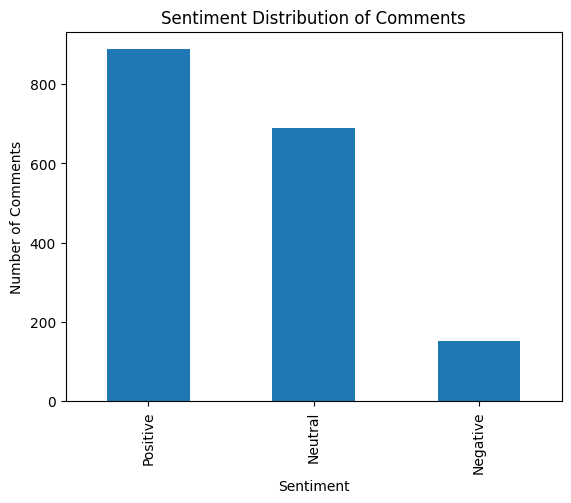

In [33]:
# distribution des commentaires en fonction des sentiments
df["sentiment_label"].value_counts().plot(kind='bar', title='Sentiment Distribution')
import matplotlib.pyplot as plt
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution of Comments')
plt.show()

# ALLOCINE MODEL

In [105]:
from transformers import pipeline

# Use PyTorch instead of TensorFlow
# classifier = pipeline(
#     "text-classification",
#     model="camembert-base",
#     framework="pt"  # Explicitly specify PyTorch
# )

classifier = pipeline(
    "sentiment-analysis",
    model="tblard/tf-allocine",
    framework="pt"
)


ImportError: 
TFCamembertForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [116]:
! pip install tensorflow
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine")
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine",from_tf=True)

nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached h5py-3.14.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 7.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ImportError: 
TFAutoModelForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [11]:
# CamemBERT pour le français
from transformers import pipeline

# classifier = pipeline(
#     "sentiment-analysis",
#     model="tblard/tf-allocine",  # Spécialisé français
#     tokenizer="tblard/tf-allocine"
# )

# Ou pour multilingue
classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


# Ecriture du fichier

In [34]:
df.to_csv('database_sentiment_label.csv', index=False)

In [1]:
from transformers import pipeline

classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
)

/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


In [7]:
import pickle
path = "../ressources/sentimentnmodel.pkl"
import os 
os.makedirs("../ressources", exist_ok=True)
with open(path, "wb") as mdl:
    pickle.dump(classifier, mdl)

In [7]:
df_yt['label']= df_yt['text_fr'].apply(lambda x: classifier(x)[0].get('label'))

df_yt

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,text_fr,label
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1,Quelqu'un sait quel film c'est ?,neutral
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17,Le fait qu'ils se retiennent tout en étant aus...,negative
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27,Vous attendez la prochaine vidéo ?,neutral
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27,Merci pour la grande vidéo. Je ne comprends pa...,negative
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2,"C'est comme ça qu'on est en Amérique, à l'exce...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,UgyhNXeIJU52Tq5k6EV4AaABAg,IEf1KAcK6A8,ES6 JavaScript Tutorial for Beginners - Gettin...,@VishalDeepVerma1,UCdMKjjzlm68fwnLhbCROddw,"The best tutorial !! Do't go anywhere, you can...",Positive,0,1,2017-09-11 05:16:30,DE,27,"Le meilleur tutoriel !! Ne partez pas, vous ne...",positive
24996,Ugwg_ThYp_qokkNGSiN4AaABAg_aug,MModz5jafy0,Bigger isn’t always better!,AugmentedUser,AugmentedCID,"Yeah, but the big hammer looks like it has a g...",Negative,0,0,2025-02-04 01:28:18,GB,26,"Oui, mais le gros marteau a l'air d'avoir un i...",neutral
24997,UgxTW8JBkQ-DoEfJpnl4AaABAg,RABj7jsRVCM,Update from Ukraine | Wow! Ukraine moves in! ...,@bill7243,UCD3QddGQrFDpqRCvBvKswIg,"Many thanks Dennis, keep up the hope and your ...",Positive,19,0,2025-01-12 08:51:04,AU,25,"Merci Dennis, gardez l'espoir et votre grand h...",positive
24998,UgwMGbs4K6EF4VlZAfV4AaABAg,2jWyuONvW1k,BREAKING NEWS: TOMMY ROBINSON SPEAKS FROM PRIS...,@donnaweetch7589,UCDRNvvjd7gtdSEUz9ESXVlA,"This is disgusting, where are the human rights...",Negative,1,0,2025-01-10 16:52:58,GB,25,"C'est dégoûtant, où sont les gens des droits h...",negative


In [16]:
from transformers import pipeline

classifier = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
)

predictions_roberta = []
for text in w_test:
    res = classifier(text)[0]
    sentiment =res.get('label')
    if sentiment == "positif":
        predictions_roberta.append(2) # positive
    elif sentiment == "negatif":
        predictions_roberta.append(0)
    elif sentiment == "neutral":
        predictions_roberta.append(1)
    else:
        predictions_roberta.append(1)

y_pred_roberta = np.array(predictions_roberta)

print(y_pred_roberta)
print("RÉSULTATS roberta:")
print(f"Classification Report:\n{classification_report(y_test, y_pred_roberta)}")
acc_roberta = accuracy_score(y_test, y_pred_roberta)
print(f"Accuracy: {acc_roberta:.4f}")
fscore_roberta = f1_score(y_test, y_pred_roberta, average='weighted')
print(f"F1 Score: {fscore_roberta:.4f}\n")

[1 1 1 ... 1 1 1]
RÉSULTATS roberta:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1707
           1       0.34      1.00      0.50      1684
           2       0.00      0.00      0.00      1609

    accuracy                           0.34      5000
   macro avg       0.11      0.33      0.17      5000
weighted avg       0.11      0.34      0.17      5000

Accuracy: 0.3368
F1 Score: 0.1697



/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carla/Desktop/GitHub/Projet-RNCP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [18]:
for i, text in enumerate(df_yt['text_fr'][:100]):
    print(text)
    res = classifier(text)[0]
    sentiment =res.get('label')
    label = df_yt['Sentiment'].iloc[i]
    print(label)
    print(sentiment)
    print("____________________________")

Quelqu'un sait quel film c'est ?
Neutral
neutral
____________________________
Le fait qu'ils se retiennent tout en étant aussi agressifs .
Positive
negative
____________________________
Vous attendez la prochaine vidéo ?
Neutral
neutral
____________________________
Merci pour la grande vidéo. Je ne comprends pas pourquoi la DB continue d'être accessible par le port 8080 lorsque la machine locale se connecte au conteneur docker par le port 5432? Ou, pourquoi n'est-il pas possible de faire des requêtes GET au port 5432 sur ma machine locale? Est-ce juste parce que le port 5432 est seulement le port utilisé pour connecter l'application à la base de données, mais l'application elle-même est toujours en charge HTTP à travers 8080?
Neutral
negative
____________________________
C'est comme ça qu'on est en Amérique, à l'exception de New York et DC.
Positive
negative
____________________________
Dei løk de seim
Neutral
neutral
____________________________
Numéro deux parce qu'il semble le meill

In [15]:
commentaire = "Cette vidéo est géniale, j'ai adoré !"
resultat = classifier(commentaire)
print(resultat[0].get('label'))

positive


# entrainement des modèle classiques sur le résultat du transformer

In [ ]:
# connexion à la base de données 

# récuprération des données

#